# Prasid 

# PH21B007

# Be Atom

In [1]:
# importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm                                
from numba import njit
import math
from matplotlib.ticker import FormatStrFormatter
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

To run this file numpy, pandas, matplotlib, tqdm, numba, math these libraries are needed.

If you are getting module not found kind of error then write ! pip install lib_name at the top of the file before importing the lbraries.

e.g. ! pip install numpy

In [2]:
# Setting Matplotlib plotting defaults
# Font
mpl.rcParams['font.family']           ='Serif'    # Setting Font family
mpl.rcParams['font.size']             = 18        # Setting Font size
# Figure
mpl.rcParams["figure.figsize"]        = (11, 7)   # Setting Figure size nearly equal to A4 sheet size
mpl.rcParams['savefig.dpi']           = 300       # Setting plot quality
mpl.rcParams['figure.dpi']            = 300       # High resolution for print quality
# Legend
mpl.rcParams["legend.fontsize"]       = 15        # Legend fontsize
mpl.rcParams["legend.title_fontsize"] = 15        # Legend fontsize
# Grid
mpl.rcParams["axes.grid"]             = True      # Setting grid to display
mpl.rcParams["grid.color"]            ='black'    # Setting grid color
mpl.rcParams['grid.linestyle']        ='--'       # Setting grid linestyle
mpl.rcParams['grid.linewidth']        = 0.5       # Setting grid linewidth
mpl.rcParams['grid.color']            ='gray'     # Setting grid color as gray
# xticks
mpl.rcParams["xtick.minor.visible"]   = True      # Setting visibility of xticks
mpl.rcParams['xtick.minor.width']     = 1.0       # Setting width of minor xticks
mpl.rcParams['xtick.major.width']     = 1.0       # Setting width of major xticks
mpl.rcParams['xtick.direction']       ='inout'    # Setting directions of xticks
mpl.rcParams['xtick.minor.size']      = 5         # Setting size of minor xticks
mpl.rcParams['xtick.major.size']      = 8         # Setting size of major xticks
mpl.rcParams['xtick.top']             = True      # Setting visibility of top minor xticks
# yticks
mpl.rcParams["ytick.minor.visible"]   = True      # Setting visibility of yticks
mpl.rcParams['ytick.minor.width']     = 1.0       # Setting width of minor yticks
mpl.rcParams['ytick.major.width']     = 1.0       # Setting width of major xticks
mpl.rcParams['ytick.direction']       ='inout'    # Setting directions of yticks
mpl.rcParams['ytick.minor.size']      = 5         # Setting size of minor xticks
mpl.rcParams['ytick.major.size']      = 8         # Setting size of major xticks
mpl.rcParams['ytick.right']           = True      # Setting visibility of top minor xticks

## Trial Wavefunctions

In [3]:
# trial wave functions

@njit() 
# trial wave function : psi_t1 = e^(-a*(r_1 + r_2))
def psi_t1(r, a, b):
    c = 0.0  
    for i in range(2): # loop over electrons
        dis = 0.0
        for j in range(3): # Loop over x, y, z
            dis += r[i,j]**2
        c += math.sqrt(dis)  # calculating the distance
    return math.exp(-c * a)                            

@njit()
# trial wave function : psi_t2 = e^(-a*(r_1 + r_2)) * (1 + b*r_12 )
def psi_t2(r, a, b):
    c = 0.0  
    for i in range(2): # loop over electrons
        dis = 0.0
        for j in range(3): # Loop over x, y, z
            dis += r[i,j]**2
        c += math.sqrt(dis)  # calculating the distance
    
    r_12 = 0.0 # Calculate r_12 (distance between electrons)
    for j in range(3): # Loop over x, y, z          
        r_12 += (r[0,j] - r[1,j])**2
    r_12 = math.sqrt(r_12)  
    
    return math.exp(-c * a) * (1 + b*r_12)

@njit()
# trial wave function : psi_t3 = e^(-a*(r_1 + r_2)) * e^(r_12 / (2*(1 + b*r_12)))
def psi_t3(r, a, b):
    c = 0.0  
    for i in range(2): # Loop over electrons
        dis = 0.0
        for j in range(3): # Loop over x, y, z
            dis += r[i,j]**2
        c += math.sqrt(dis)  # calculating the distance
    
    r_12 = 0.0 # Calculate r_12 (distance between electrons)
    for j in range(3): # Loop over x, y, z          
        r_12 += (r[0,j] - r[1,j])**2
    r_12 = math.sqrt(r_12)  
    
    return math.exp(-c * a) * math.exp(r_12/(2*(1 + b*r_12)))

## Local Energy

In [4]:
@njit # Local energy for psi_t1
def local_energy_1(r, a, b, z):
    r1 = 0
    for i in range(3): # Loop over x, y, z 
        r1 += r[0,i]**2
    r1 = math.sqrt(r1) # calculating the norm
       
    r2 = 0
    for i in range(3): # Loop over x, y, z 
        r2 += r[1,i]**2
    r2 = math.sqrt(r2) # calculating the norm
       
    r12 = 0.0  # Calculate r_12 (distance between electrons)
    for k in range(3): # Loop over x, y, z 
        r12 += (r[0,k]-r[1,k])**2
    r12 = math.sqrt(r12) 
    
    E = (a - z)*(1/r1 + 1/r2) + 1/r12 - a**2 
    return E


@njit # Local energy for psi_t2
def local_energy_2(r, a, b, z):
    eps = 1e-9  # we are adding the small values so that in denominator we don't get zero.
    r1 = 0
    for i in range(3): # Loop over x, y, z 
        r1 += r[0,i]**2
    r1 = math.sqrt(r1) + eps # calculating the norm
       
    r2 = 0
    for i in range(3): # Loop over x, y, z 
        r2 += r[1,i]**2
    r2 = math.sqrt(r2) + eps # calculating the norm
       
    r12 = 0.0 # Calculate r_12 (distance between electrons)
    for k in range(3): # Loop over x, y, z 
        r12 += (r[0,k]-r[1,k])**2
    r12 = math.sqrt(r12) + eps 
    
    r1dotr2 = eps  # calculate r1.r2
    for i in range(3):
        r1dotr2 += r[0,i]*r[1,i]
        
    T_dot = (r1**2 - r2**2 + r12**2)/(2 * r1 * r12) + (r2**2 - r1**2 + r12**2)/(2 * r2 * r12)  # this is r1.r2
    
    E = (a - z)*(1/r1 + 1/r2) + 1/r12 - a**2 + b/(1 + b*r12) * (-2/r12 + a * T_dot) 
    return E


@njit # Local energy for psi_t3
def local_energy_3(r, a, b, z):
    r1 = 0
    for i in range(3): # Loop over x, y, z 
        r1 += r[0,i]**2
    r1 = math.sqrt(r1) 
       
    r2 = 0
    for i in range(3): # Loop over x, y, z 
        r2 += r[1,i]**2
    r2 = math.sqrt(r2) 
       
    r12 = 0.0
    for k in range(3): # Loop over x, y, z 
        r12 += (r[0,k]-r[1,k])**2
    r12 = math.sqrt(r12)
    
    r1dotr2 = 0 # calculate r1.r2
    for i in range(3):
        r1dotr2 += r[0,i]*r[1,i] 
    
    E = (a - z)*(1/r1 + 1/r2) + 1/r12 - a**2 + 0.5/(1 + b*r12)**2 * (a*((r1 + r2)/r12) * (1 - r1dotr2/(r1*r2)) - 0.5/(1 + b*r12)**2 - 2/r12 + 2*b/(1 + b*r12)) 
    return E

## Monte Carlo algorithm

In [5]:
@njit() # function to perform the monte carlo swip

def mc_swip(psi, r, a, b, z, s):
    rand_pos = np.random.rand(2, 3)
    r_new = r + s * (rand_pos - 0.5)    # propose new positions for both electrons
    
    psi_old = psi(r, a, b)
    psi_new = psi(r_new, a, b)
    ratio = (psi_new / psi_old)**2  # acceptance probability
    
    if np.random.rand() < ratio:   # Metropolis Algorithm
        return r_new 
    else:
        return r

In [6]:
# function to do the monte carlo iterations and store the necessary quantities
@njit(fastmath=True)
def vmc(psi, local_energy, a, b, z, n, n_th, s):
    r = np.random.rand(2, 3) * s - s/2    # initialize electrons randomly
    
    for i in range(int(n_th)):  # thermalization
        r = mc_swip(psi, r, a, b, z, s)
    
    e_local = np.zeros(int(n), dtype=np.float64)    
    for i in range(n):                        # Monte carlo sampling
        r = mc_swip(psi, r, a, b, z, s)
        e_local[i] = local_energy(r, a, b, z)
        
    e_mean = np.mean(e_local) # taking the mean of local energy over all the n iterations
    e_var = np.var(e_local)   # variance of local energy
    
    return e_mean, e_var

In [7]:
@njit(fastmath=True)  # function to calculate the the mean distance r_12
def r12(psi, local_energy, a, b, z, n, n_th, s):
    r = np.random.rand(2, 3) * s - s/2    # initialize electrons randomly
    
    for i in range(int(n_th)):  # thermalization
        r = mc_swip(psi, r, a, b, z, s)
     
    r12_t = 0
    for i in range(n):                        # Monte carlo sampling
        r = mc_swip(psi, r, a, b, z, s)
        r_12 = 0.0
        for k in range(3):
            r_12 += (r[0,k]-r[1,k])**2
        r12 = math.sqrt(r_12)
        
        r12_t += r12
        
    return r12_t / n

## Performing the actual calculations

# Ansatz  1 

In [8]:
# scanning alpha values
a_val_1 = np.arange(3.2, 4.2, 0.1)    # a values
s = 1.0                               # step length
n_th = 1e3                            # thermalization iterations
n = 1e7                               # no. of monte carlo iterations
b = 1                                 # for psi_t1 b is free parameter 
z = 4                                 # for Berylium charge = 4

energy_1 = []  # empty lists to store the values
var_1 = []

for a in tqdm(a_val_1):  # loop over all alpha values
    e, v = vmc(psi_t1, local_energy_1, a, b, z, n, n_th, s)
    energy_1.append(e)
    var_1.append(v)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.29s/it]


In [9]:
# Find optimal alphas for energy and variance.
opt_alpha_en_1 = a_val_1[np.argmin(energy_1)]
print(f"Optimal a = {opt_alpha_en_1:.2f}, Energy = {np.min(energy_1):.6f} (in atomic units) or {4*13.6*np.min(energy_1):.6f} (in eV)")

opt_alpha_var_1 = a_val_1[np.argmin(var_1)]
print(f"Optimal a = {opt_alpha_var_1:.2f}, Variance = {np.min(var_1):.6f} (in atomic units)")

r12_1 = r12(psi_t1, local_energy_1, opt_alpha_en_1, b, z, n, n_th, s)
print(f"mean distance r_{12} = {r12_1:.2f}")

Optimal a = 3.70, Energy = -13.596474 (in atomic units) or -739.648179 (in eV)
Optimal a = 3.90, Variance = 3.515002 (in atomic units)
mean distance r_12 = 0.59


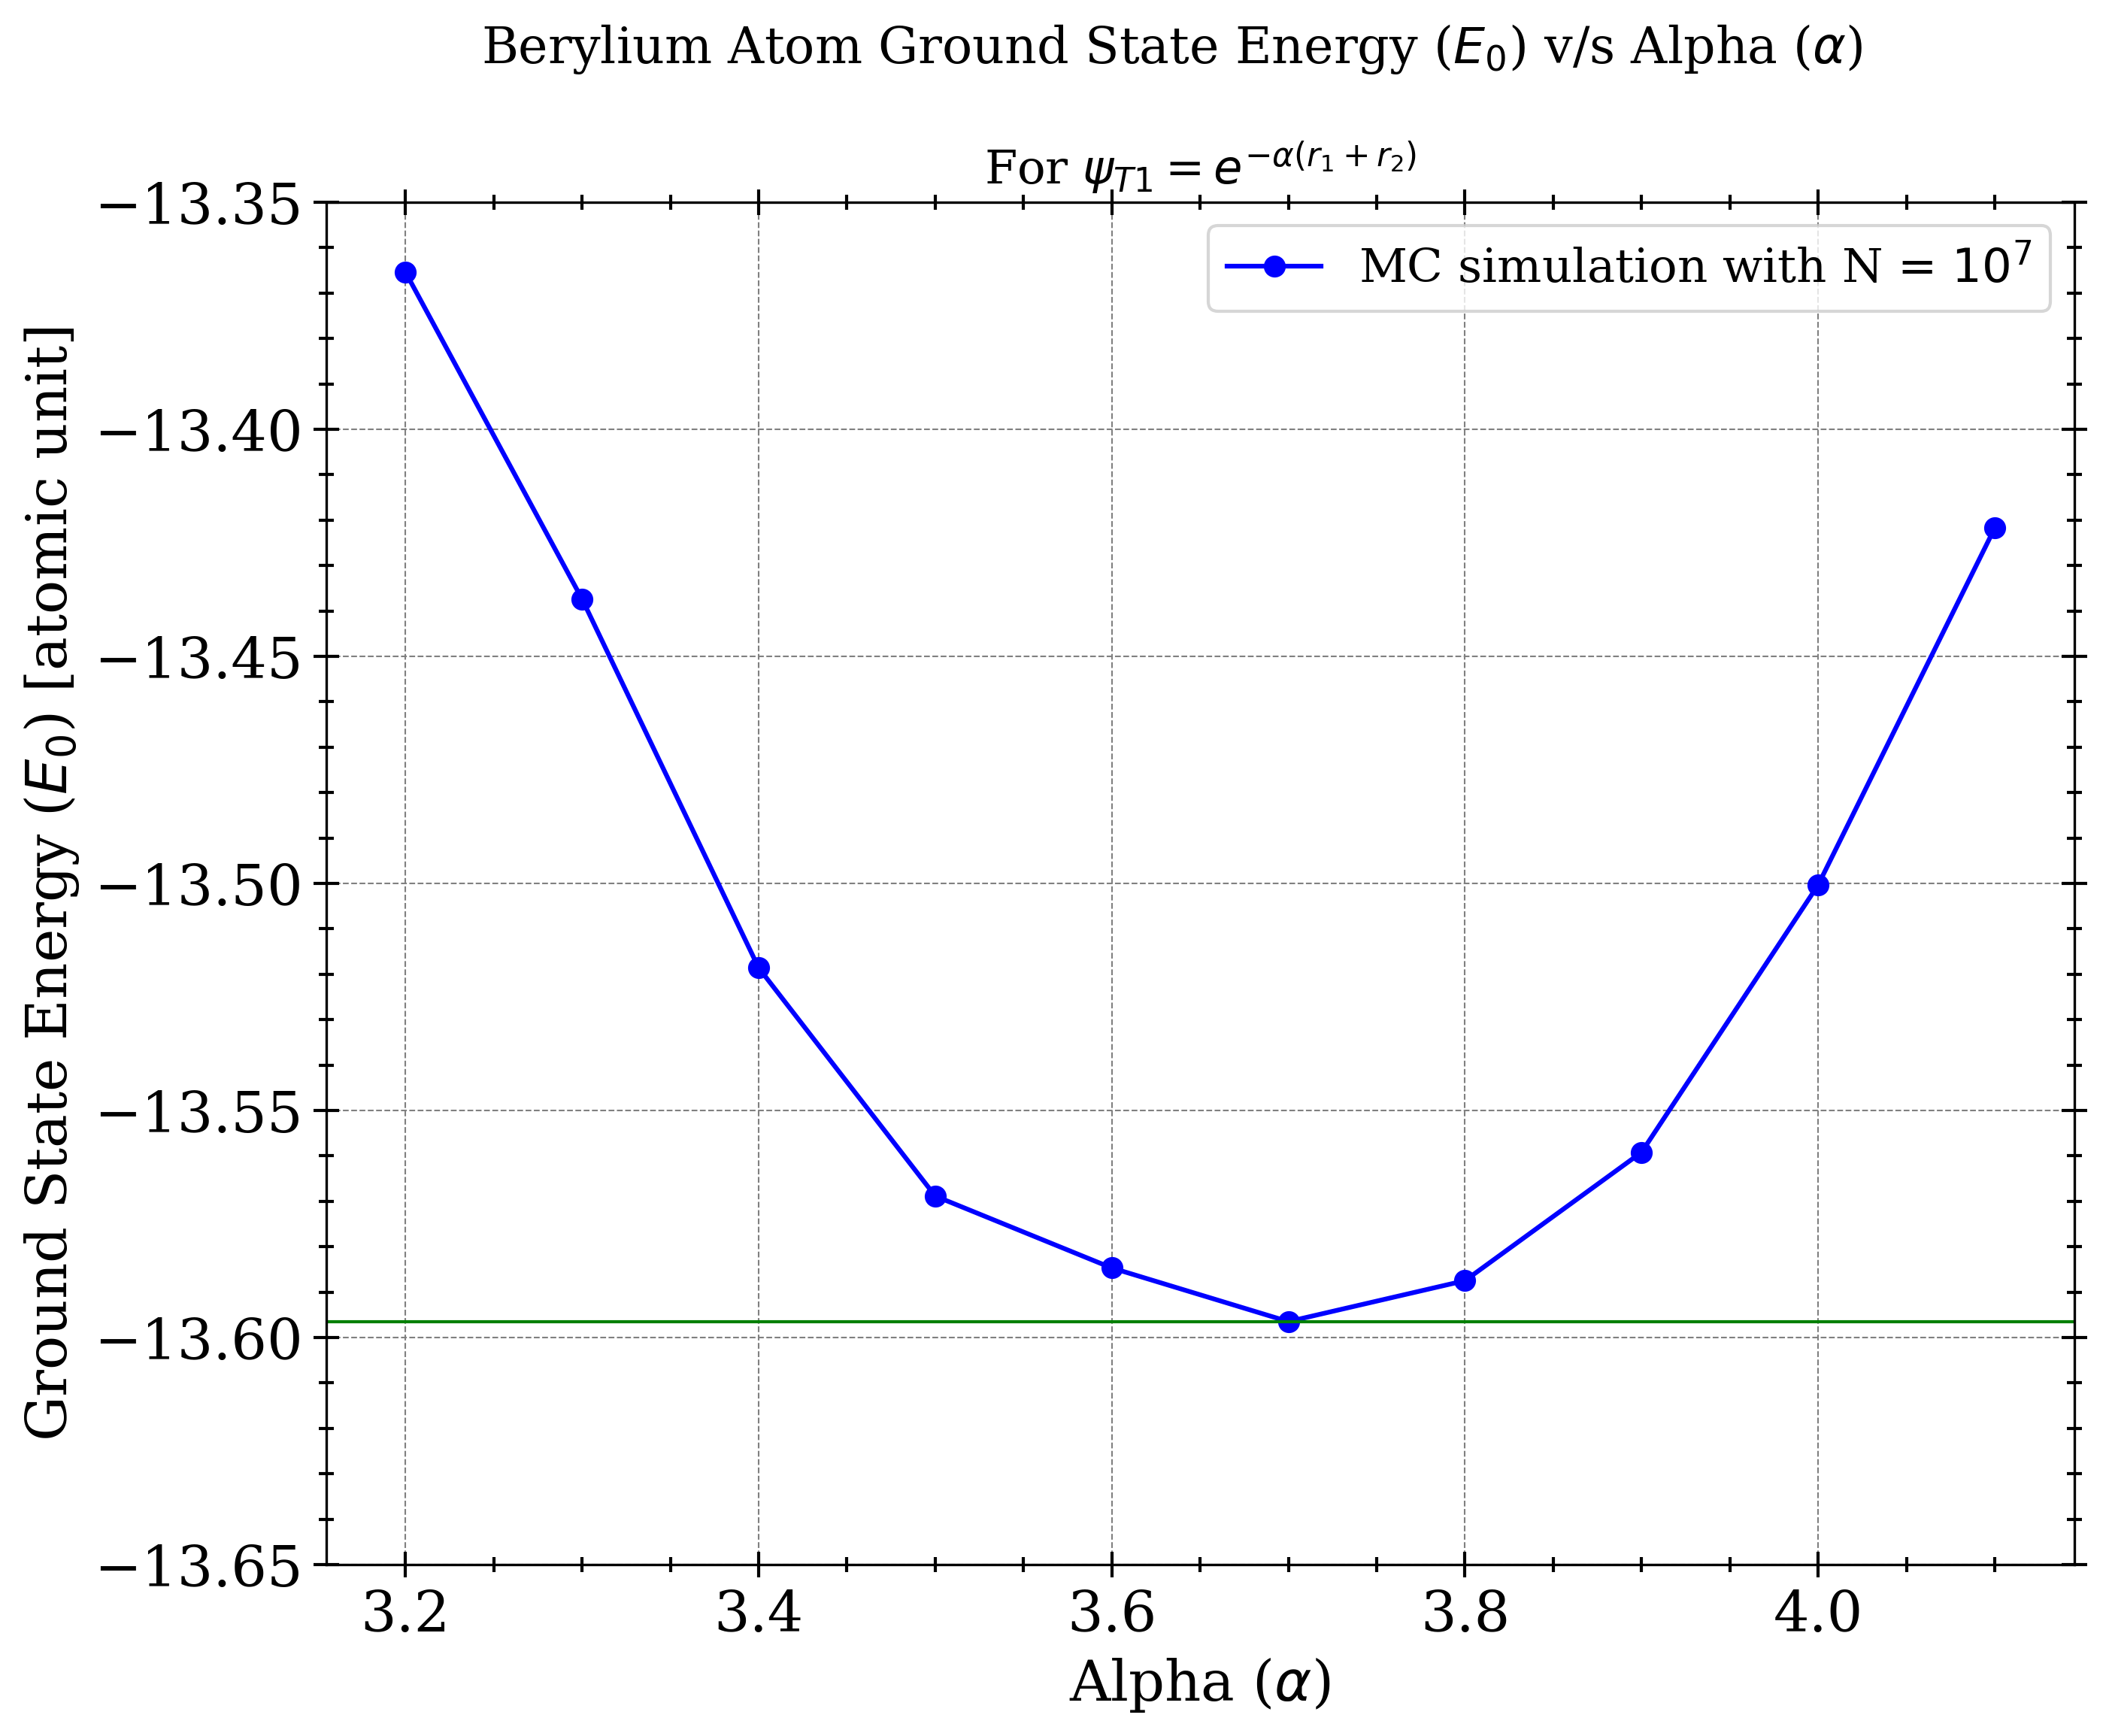

In [10]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.plot(a_val_1, energy_1, 'bo-', label = r'MC simulation with N = $10^7$')
plt.xlabel(r'Alpha ($\alpha$)')
plt.ylabel(r'Ground State Energy ($E_{0}$) [atomic unit]')
plt.suptitle('Berylium Atom Ground State Energy ($E_0$) v/s Alpha ($\\alpha$)', fontsize=16)
plt.title('For $\\psi_{T1} = e^{-\\alpha(r_1 + r_2)}$', fontsize=15)
plt.axhline(y = np.min(energy_1), color='g', linestyle='-', linewidth=1)
yticks = set(np.round(plt.yticks()[0], 2))
yticks.add(round(np.min(energy_1), 2))
plt.yticks(sorted(yticks))
plt.legend()
plt.grid(True)

In [11]:
# making the dataframe contaning the mean energy and varivance for each value of alpha
df_1 = pd.DataFrame({r'Parameter $\alpha$': a_val_1, r'Mean Energy $<H>$': energy_1, r' Variance $\sigma^{2}$': var_1})

print('anstaz 1 ')
df_1

anstaz 1 


Parameter $\alpha$  Mean Energy $<H>$   Variance $\sigma^{2}$
0                 3.2         -13.365396               11.555787
1                 3.3         -13.437376                9.136518
2                 3.4         -13.518585                9.238703
3                 3.5         -13.568838                6.638261
4                 3.6         -13.584666                4.761242
5                 3.7         -13.596474                4.680250
6                 3.8         -13.587464                4.155068
7                 3.9         -13.559187                3.515002
8                 4.0         -13.500326                4.192821
9                 4.1         -13.421745                7.886743

In [12]:
# Convert DataFrame to LaTeX table string
latex_table_1 = df_1.to_latex(
    index=False,           # Exclude index column
    header=True,           # Include column headers
    float_format="%.6f",   # Format float values
    caption="Sample Table", # Add caption
    label="tab:sample_table", # Add label for referencing
    column_format="lcc"    # Align columns (left, center, center)
)

# Print the LaTeX table string
print(latex_table_1)

\begin{table}
\centering
\caption{Sample Table}
\label{tab:sample_table}
\begin{tabular}{lcc}
\toprule
 Parameter \$\textbackslash alpha\$ &  Mean Energy \$<H>\$ &   Variance \$\textbackslash sigma\textasciicircum \{2\}\$ \\
\midrule
           3.200000 &         -13.365396 &               11.555787 \\
           3.300000 &         -13.437376 &                9.136518 \\
           3.400000 &         -13.518585 &                9.238703 \\
           3.500000 &         -13.568838 &                6.638261 \\
           3.600000 &         -13.584666 &                4.761242 \\
           3.700000 &         -13.596474 &                4.680250 \\
           3.800000 &         -13.587464 &                4.155068 \\
           3.900000 &         -13.559187 &                3.515002 \\
           4.000000 &         -13.500326 &                4.192821 \\
           4.100000 &         -13.421745 &                7.886743 \\
\bottomrule
\end{tabular}
\end{table}



# Ansatz 2

In [13]:
# scanning beta values
b_val_2 = np.arange(-0.1, 1, 0.1)     # b values
s = 1.0                               # step length
n_th = 1e3                            # thermalization iterations
n = 1e7                               # no. of monte carlo iterations
a = a_val_1[np.argmin(energy_1)]      # putting the alpha equal to alpha min. we got from the anstaz 1
z = 4                                 # for Berylium charge = 4

energy_2 = []  # empty lists to store the values
var_2 = []

for b in tqdm(b_val_2):  # loop over all alpha values
    e, v = vmc(psi_t2, local_energy_2, a, b, z, n, n_th, s)
    energy_2.append(e)
    var_2.append(v)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:09<00:00,  6.32s/it]


In [14]:
# Find optimal alphas for energy and variance.
opt_alpha_en_2 = b_val_2[np.argmin(energy_2)]
print(f"Optimal b = {opt_alpha_en_2:.2f}, Energy = {np.min(energy_2):.6f} (in atomic units) or {4*13.6*np.min(energy_2):.6f} (in eV)")

opt_alpha_var_2 = b_val_2[np.argmin(var_2)]
print(f"Optimal b = {opt_alpha_var_2:.2f}, Variance = {np.min(var_2):.6f} (in atomic units)")

r12_2 = r12(psi_t2, local_energy_2, a, opt_alpha_en_2, z, n, n_th, s)
print(f"mean distance r_{12} = {r12_2:.2f}")

Optimal b = 0.20, Energy = -13.633842 (in atomic units) or -741.680995 (in eV)
Optimal b = 0.20, Variance = 2.283336 (in atomic units)
mean distance r_12 = 0.62


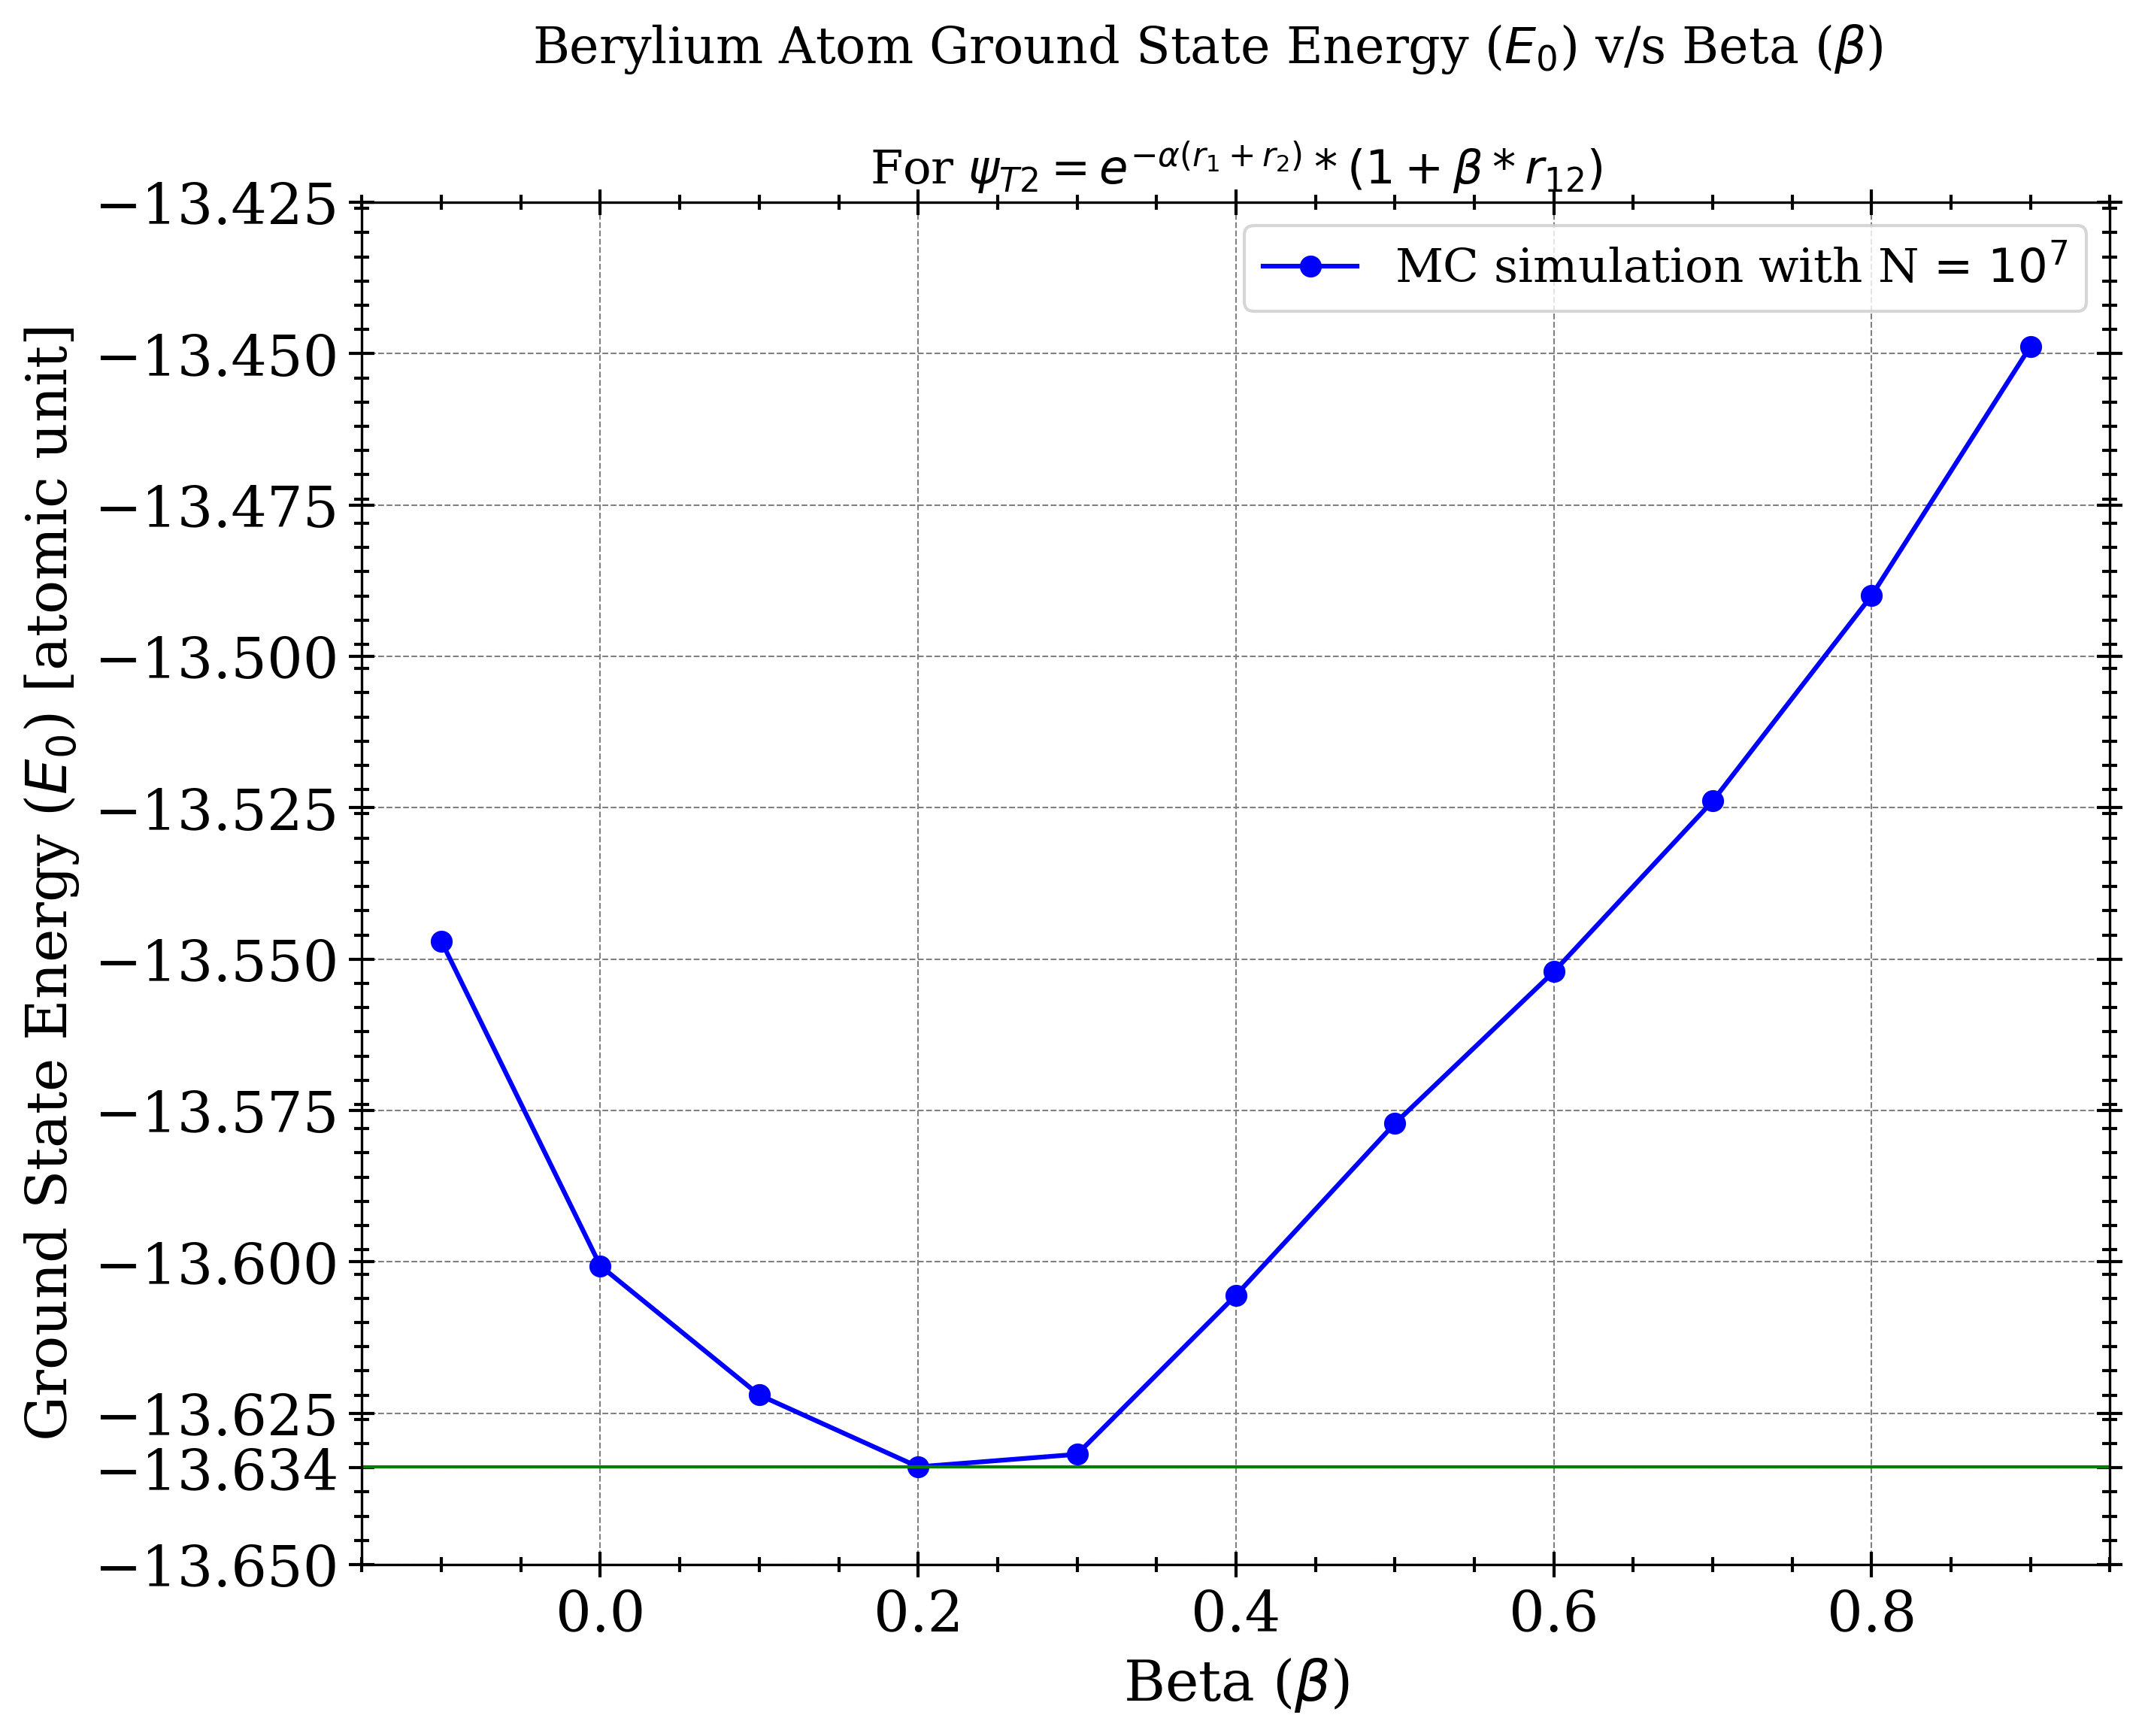

In [15]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.plot(b_val_2, energy_2, 'bo-', label = r'MC simulation with N = $10^7$')
plt.xlabel(r'Beta ($\beta$)')
plt.ylabel(r'Ground State Energy ($E_{0}$) [atomic unit]')
plt.suptitle('Berylium Atom Ground State Energy ($E_0$) v/s Beta ($\\beta$)', fontsize=16)
plt.title('For $\\psi_{T2} = e^{-\\alpha(r_1 + r_2)} * (1 + \\beta * r_{12})$', fontsize=15)
plt.axhline(y = np.min(energy_2), color='g', linestyle='-', linewidth=1)
yticks = set(np.round(plt.yticks()[0], 3))
yticks.add(round(np.min(energy_2), 3))
plt.yticks(sorted(yticks))
plt.legend()
plt.grid(True)

In [16]:
# making the dataframe contaning the mean energy and varivance for each value of alpha
df_2 = pd.DataFrame({r'Parameter $\beta$': b_val_2, r'Mean Energy $<H>$': energy_2, r' Variance $\sigma^{2}$': var_2})

print('anstaz 2 ')
df_2

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
anstaz 2 


Parameter $\beta$  Mean Energy $<H>$   Variance $\sigma^{2}$
0                -0.1         -13.547046                5.601628
1                 0.0         -13.600646                4.184184
2                 0.1         -13.621985                2.792726
3                 0.2         -13.633842                2.283336
4                 0.3         -13.631777                2.417541
5                 0.4         -13.605504                3.467196
6                 0.5         -13.577138                2.302437
7                 0.6         -13.552080                2.922995
8                 0.7         -13.523890                3.617890
9                 0.8         -13.489958                4.291602
10                0.9         -13.448770                5.076166

In [17]:
# Convert DataFrame to LaTeX table string
latex_table_2 = df_2.to_latex(
    index=False,           # Exclude index column
    header=True,           # Include column headers
    float_format="%.6f",   # Format float values
    caption="Sample Table", # Add caption
    label="tab:sample_table", # Add label for referencing
    column_format="lcc"    # Align columns (left, center, center)
)

# Print the LaTeX table string
print(latex_table_2)

\begin{table}
\centering
\caption{Sample Table}
\label{tab:sample_table}
\begin{tabular}{lcc}
\toprule
 Parameter \$\textbackslash beta\$ &  Mean Energy \$<H>\$ &   Variance \$\textbackslash sigma\textasciicircum \{2\}\$ \\
\midrule
         -0.100000 &         -13.547046 &                5.601628 \\
          0.000000 &         -13.600646 &                4.184184 \\
          0.100000 &         -13.621985 &                2.792726 \\
          0.200000 &         -13.633842 &                2.283336 \\
          0.300000 &         -13.631777 &                2.417541 \\
          0.400000 &         -13.605504 &                3.467196 \\
          0.500000 &         -13.577138 &                2.302437 \\
          0.600000 &         -13.552080 &                2.922995 \\
          0.700000 &         -13.523890 &                3.617890 \\
          0.800000 &         -13.489958 &                4.291602 \\
          0.900000 &         -13.448770 &                5.076166 \\
\bottomr

In [18]:
# scanning over the grid around the optimum values
s = 1.0             # step length
n_th = 1e3          # thermalization iterations
n = 1e7             # no. of monte carlo iterations
z = 4               # for Berylium charge = 4


# Create 2D grid of parameters
alpha_values_2 = np.linspace(3.4, 4, 5)  
beta_values_2 = np.linspace(0.1, 0.5, 5)   

# Initialize arrays to store results
energy_grid_2 = np.zeros((len(alpha_values_2), len(beta_values_2)))
variance_grid_2 = np.zeros((len(alpha_values_2), len(beta_values_2)))

# Loop over all parameter combinations
for i, a in tqdm(enumerate(alpha_values_2)):
    for j, b in (enumerate(beta_values_2)):
        # Run VMC simulation with these parameters
        e, v = vmc(psi_t2, local_energy_2, a, b, z, n, n_th, s)
        energy_grid_2[i, j] = e
        variance_grid_2[i, j] = v

5it [02:50, 34.05s/it]


In [19]:
# Find the minimum energy and corresponding parameters
min_idx = np.unravel_index(np.argmin(energy_grid_2), energy_grid_2.shape)
opt_alpha_2 = alpha_values_2[min_idx[0]]
opt_beta_2 = beta_values_2[min_idx[1]]
min_energy_2 = energy_grid_2[min_idx]

print(f"Optimal parameters: α = {opt_alpha_2:.3f}, β = {opt_beta_2:.3f}")
print(f"Minimum energy: {min_energy_2:.6f} (in atomic units) or {4*13.6*min_energy_2:.6f} (in eV)")

r12_2 = r12(psi_t2, local_energy_2, opt_alpha_2, opt_beta_2, z, n, n_th, s)
print(f"mean distance r_{12} = {r12_2:.2f}")

Optimal parameters: α = 3.850, β = 0.400
Minimum energy: -13.642208 (in atomic units) or -742.136133 (in eV)
mean distance r_12 = 0.62


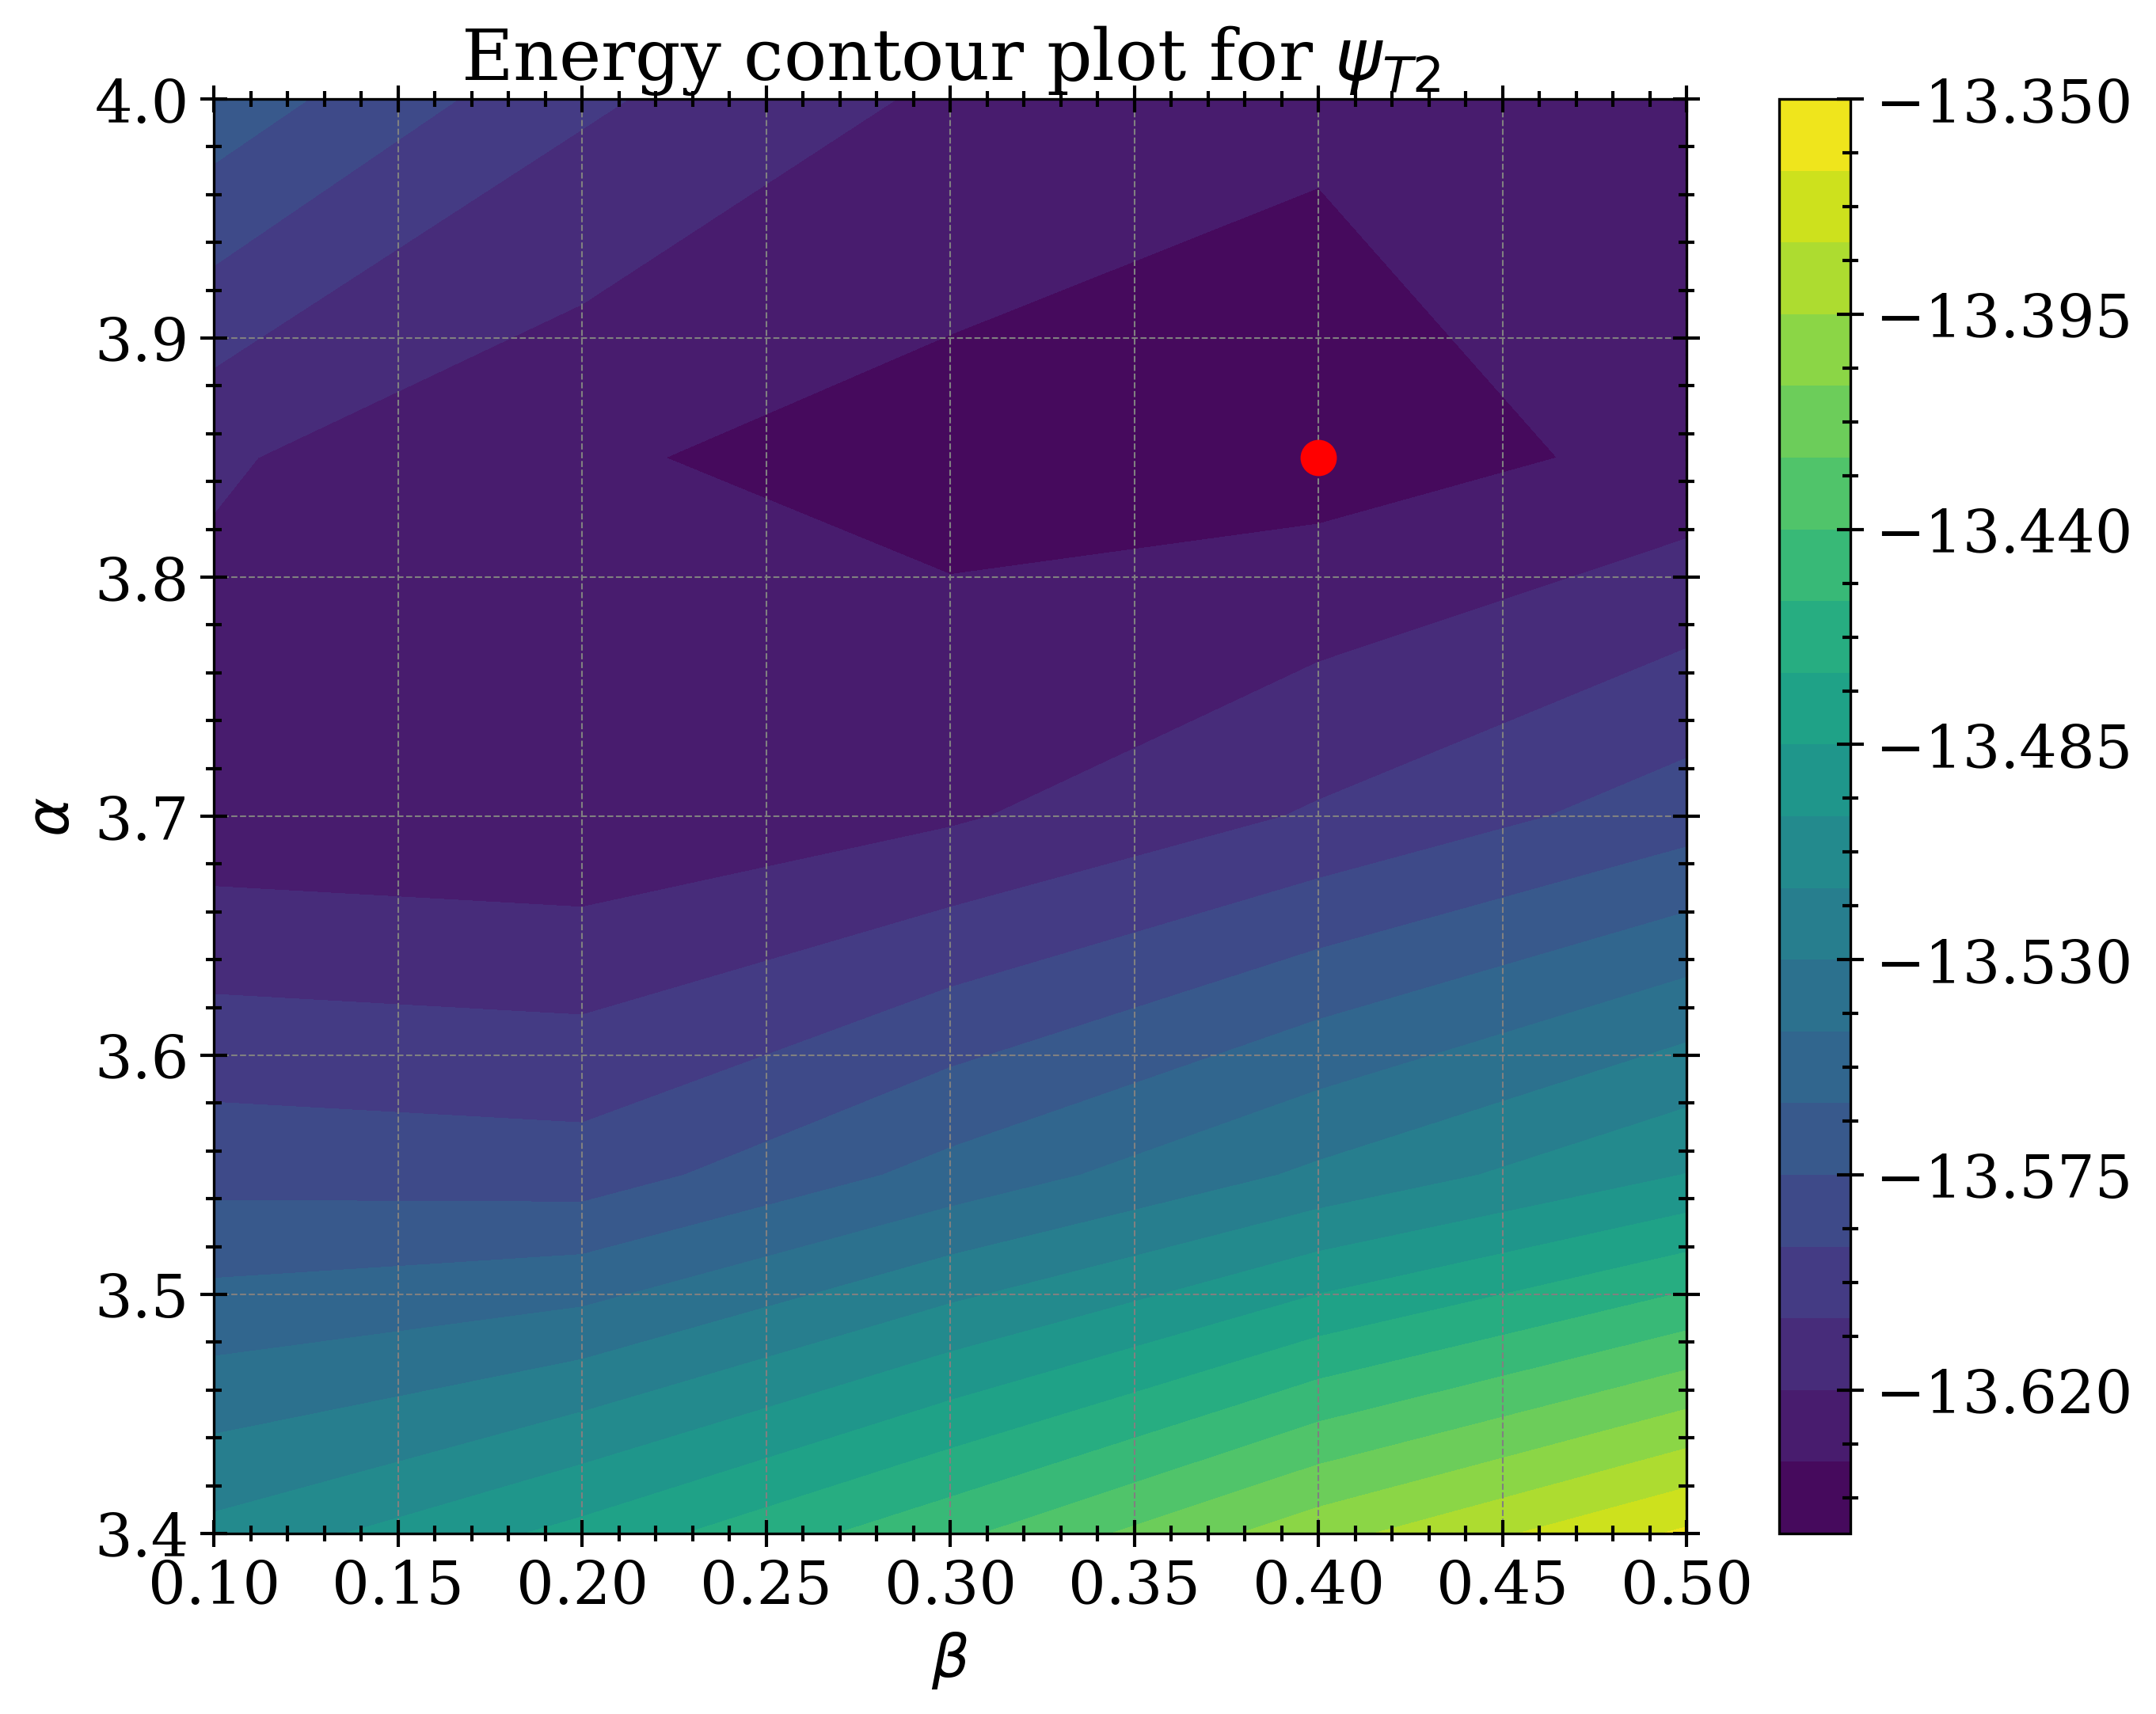

In [20]:
# Create a contour plot
fig, ax = plt.subplots(figsize=(10, 8))
X_2, Y_2 = np.meshgrid(beta_values_2, alpha_values_2)
contour_2 = ax.contourf(X_2, Y_2, energy_grid_2, 20, cmap=cm.viridis)
fig.colorbar(contour_2, ax=ax)

# Mark the minimum point
ax.plot(opt_beta_2, opt_alpha_2, 'ro', markersize=10)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\alpha$')
ax.set_title('Energy contour plot for $\psi_{T2}$')
plt.show()


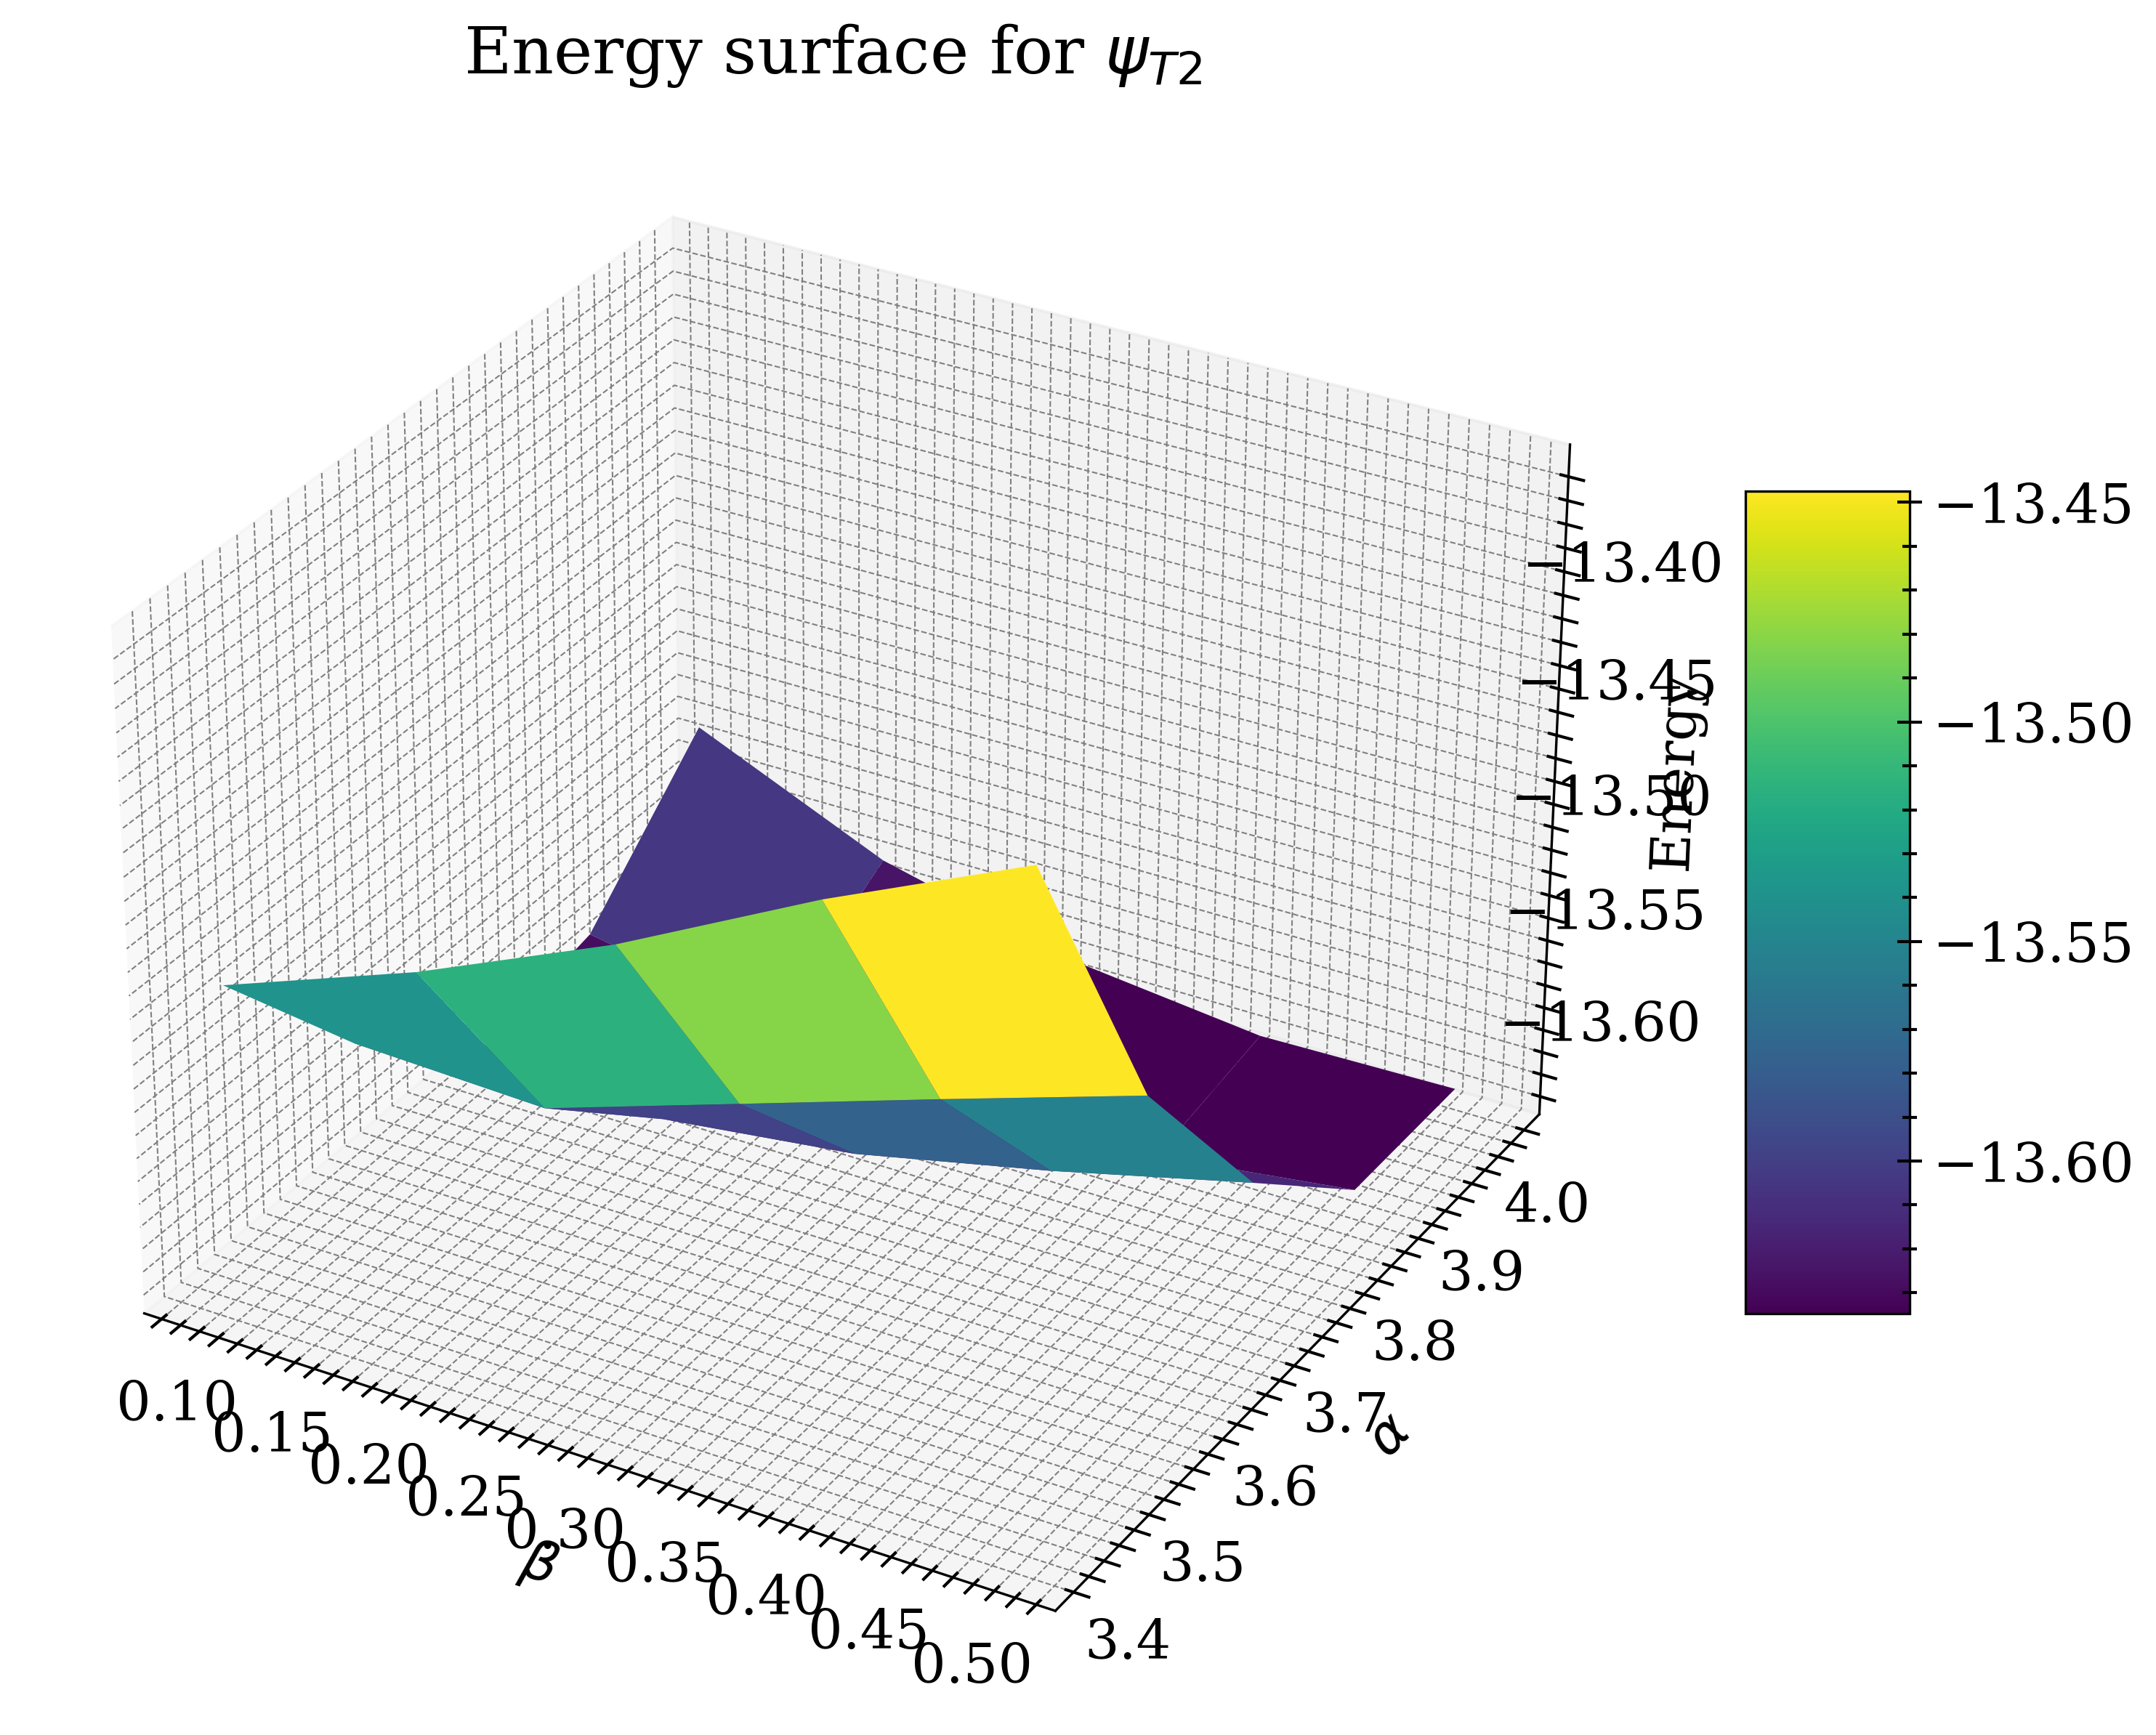

In [21]:
# create the 3-D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
surf_2 = ax.plot_surface(X_2, Y_2, energy_grid_2, cmap=cm.viridis, edgecolor='none')
fig.colorbar(surf_2, ax=ax, shrink=0.5, aspect=5)

ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\alpha$')
ax.set_zlabel('Energy')
ax.set_title('Energy surface for $\psi_{T2}$')
plt.show()

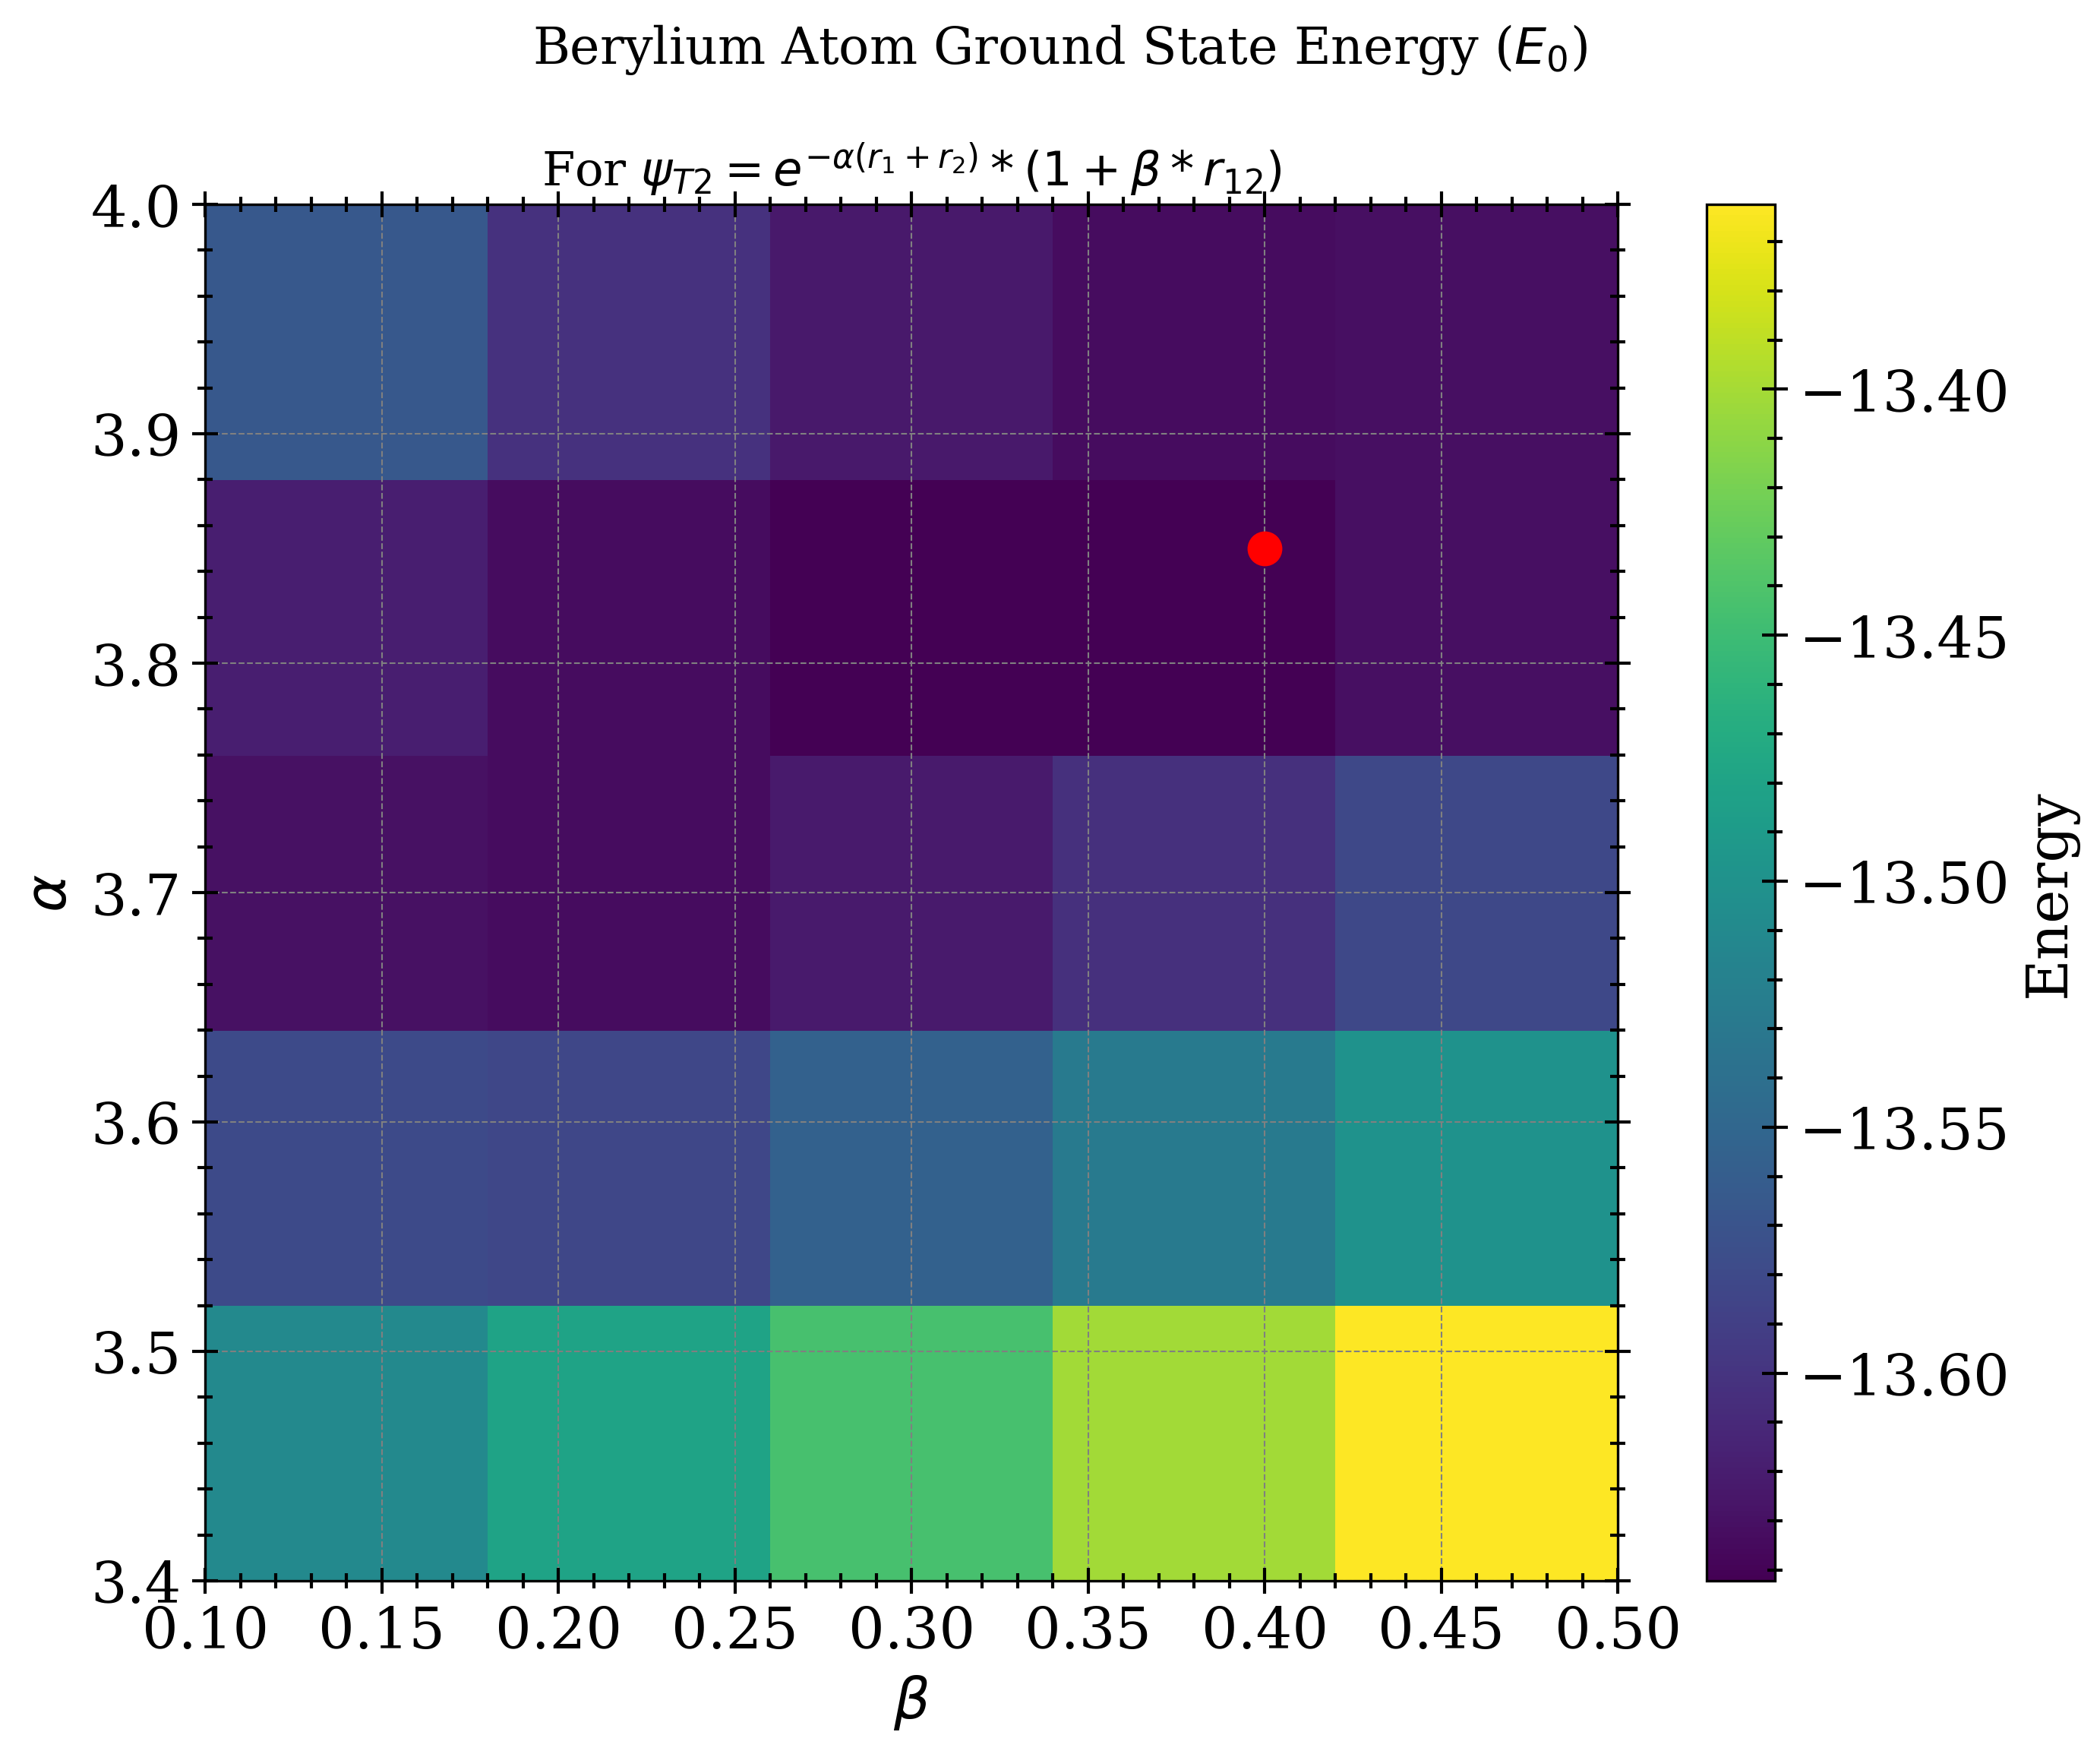

In [84]:
# create the heat map
plt.figure(figsize=(10, 8))
plt.imshow(energy_grid_2, origin='lower', extent=[beta_values_2[0], beta_values_2[-1], 
                                               alpha_values_2[0], alpha_values_2[-1]], 
           aspect='auto', cmap='viridis')
plt.plot(opt_beta_2, opt_alpha_2, 'ro', markersize=10)
plt.colorbar(label='Energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha$')
plt.suptitle('Berylium Atom Ground State Energy ($E_0$)', fontsize=16)
plt.title('For $\\psi_{T2} = e^{-\\alpha(r_1 + r_2)} * (1 + \\beta * r_{12})$', fontsize=15)
plt.show()

In [23]:
# Find the index of the minimum in e
a_idx, b_idx = np.unravel_index(np.argmin(energy_grid_2), energy_grid_2.shape)

# Select 3x3 values around the minimum
a_selected = alpha_values_2[a_idx-1:a_idx+2]
b_selected = beta_values_2[b_idx-1:b_idx+2]
e_block = energy_grid_2[b_idx-1:b_idx+2, a_idx-1:a_idx+2]
v_block = variance_grid_2[b_idx-1:b_idx+2, a_idx-1:a_idx+2]

# Flatten and create DataFrame
A, B = np.meshgrid(a_selected, b_selected)
df_2 = pd.DataFrame({
    r'$\alpha$': A.flatten(),
    r'$\beta$': B.flatten(),
    '$E$': e_block.flatten(),
    '$V$': v_block.flatten()
})

df_2

print(f"mean distance r_{12} = {r12_2:.2f}")

df_2

mean distance r_12 = 0.62


$\alpha$  $\beta$        $E$       $V$
0      3.70      0.3 -13.622014  2.060829
1      3.85      0.3 -13.603235  1.974765
2      4.00      0.3 -13.582046  2.433719
3      3.70      0.4 -13.641272  0.692849
4      3.85      0.4 -13.642208  0.710262
5      4.00      0.4 -13.631084  0.994669
6      3.70      0.5 -13.623012  0.538092
7      3.85      0.5 -13.632633  0.387790
8      4.00      0.5 -13.631023  0.547510

In [24]:
# Convert DataFrame to LaTeX table string
latex_table_2 = df_2.to_latex(
    index=False,           # Exclude index column
    header=True,           # Include column headers
    float_format="%.6f",   # Format float values
    caption="Sample Table", # Add caption
    label="tab:sample_table", # Add label for referencing
    column_format="lcc"    # Align columns (left, center, center)
)

# Print the LaTeX table string
print(latex_table_2)

\begin{table}
\centering
\caption{Sample Table}
\label{tab:sample_table}
\begin{tabular}{lcc}
\toprule
 \$\textbackslash alpha\$ &  \$\textbackslash beta\$ &        \$E\$ &      \$V\$ \\
\midrule
 3.700000 & 0.300000 & -13.622014 & 2.060829 \\
 3.850000 & 0.300000 & -13.603235 & 1.974765 \\
 4.000000 & 0.300000 & -13.582046 & 2.433719 \\
 3.700000 & 0.400000 & -13.641272 & 0.692849 \\
 3.850000 & 0.400000 & -13.642208 & 0.710262 \\
 4.000000 & 0.400000 & -13.631084 & 0.994669 \\
 3.700000 & 0.500000 & -13.623012 & 0.538092 \\
 3.850000 & 0.500000 & -13.632633 & 0.387790 \\
 4.000000 & 0.500000 & -13.631023 & 0.547510 \\
\bottomrule
\end{tabular}
\end{table}



# Anstaz 3

In [80]:
# scanning beta values
b_val_3 = np.arange(0, 1.5, 0.1 )       # b values
s = 1.0                               # step length
n_th = 1e3                            # thermalization iterations
n = 1e7                               # no. of monte carlo iterations
a = a_val_1[np.argmin(energy_1)]      # putting the alpha equal to alpha min. we got from the anstaz 1lpha min. we got from the anstaz 1
z = 4                                 # for Berylium charge = 4

energy_3 = []  # empty lists to store the values
var_3 = []

for b in tqdm(b_val_3):  # loop over all alpha values
    e, v = vmc(psi_t3, local_energy_3, a, b, z, n, n_th, s)
    energy_3.append(e)
    var_3.append(v)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:30<00:00,  6.06s/it]


In [81]:
# Find optimal alphas for energy and variance.
opt_alpha_en_3 = b_val_3[np.argmin(energy_3)]
print(f"Optimal b = {opt_alpha_en_3:.2f}, Energy = {np.min(energy_3):.6f} (in atomic units) or {4*13.6*np.min(energy_3):.6f} (in eV)")

opt_alpha_var_3 = b_val_3[np.argmin(var_3)]
print(f"Optimal b = {opt_alpha_var_3:.2f}, Variance = {np.min(var_3):.6f} (in atomic units)")

r12_3 = r12(psi_t3, local_energy_3, a, opt_alpha_en_3, z, n, n_th, s)
print(f"mean distance r_{12} = {r12_3:.2f}")

Optimal b = 1.20, Energy = -13.635791 (in atomic units) or -741.787024 (in eV)
Optimal b = 1.30, Variance = 1.627593 (in atomic units)
mean distance r_12 = 0.62


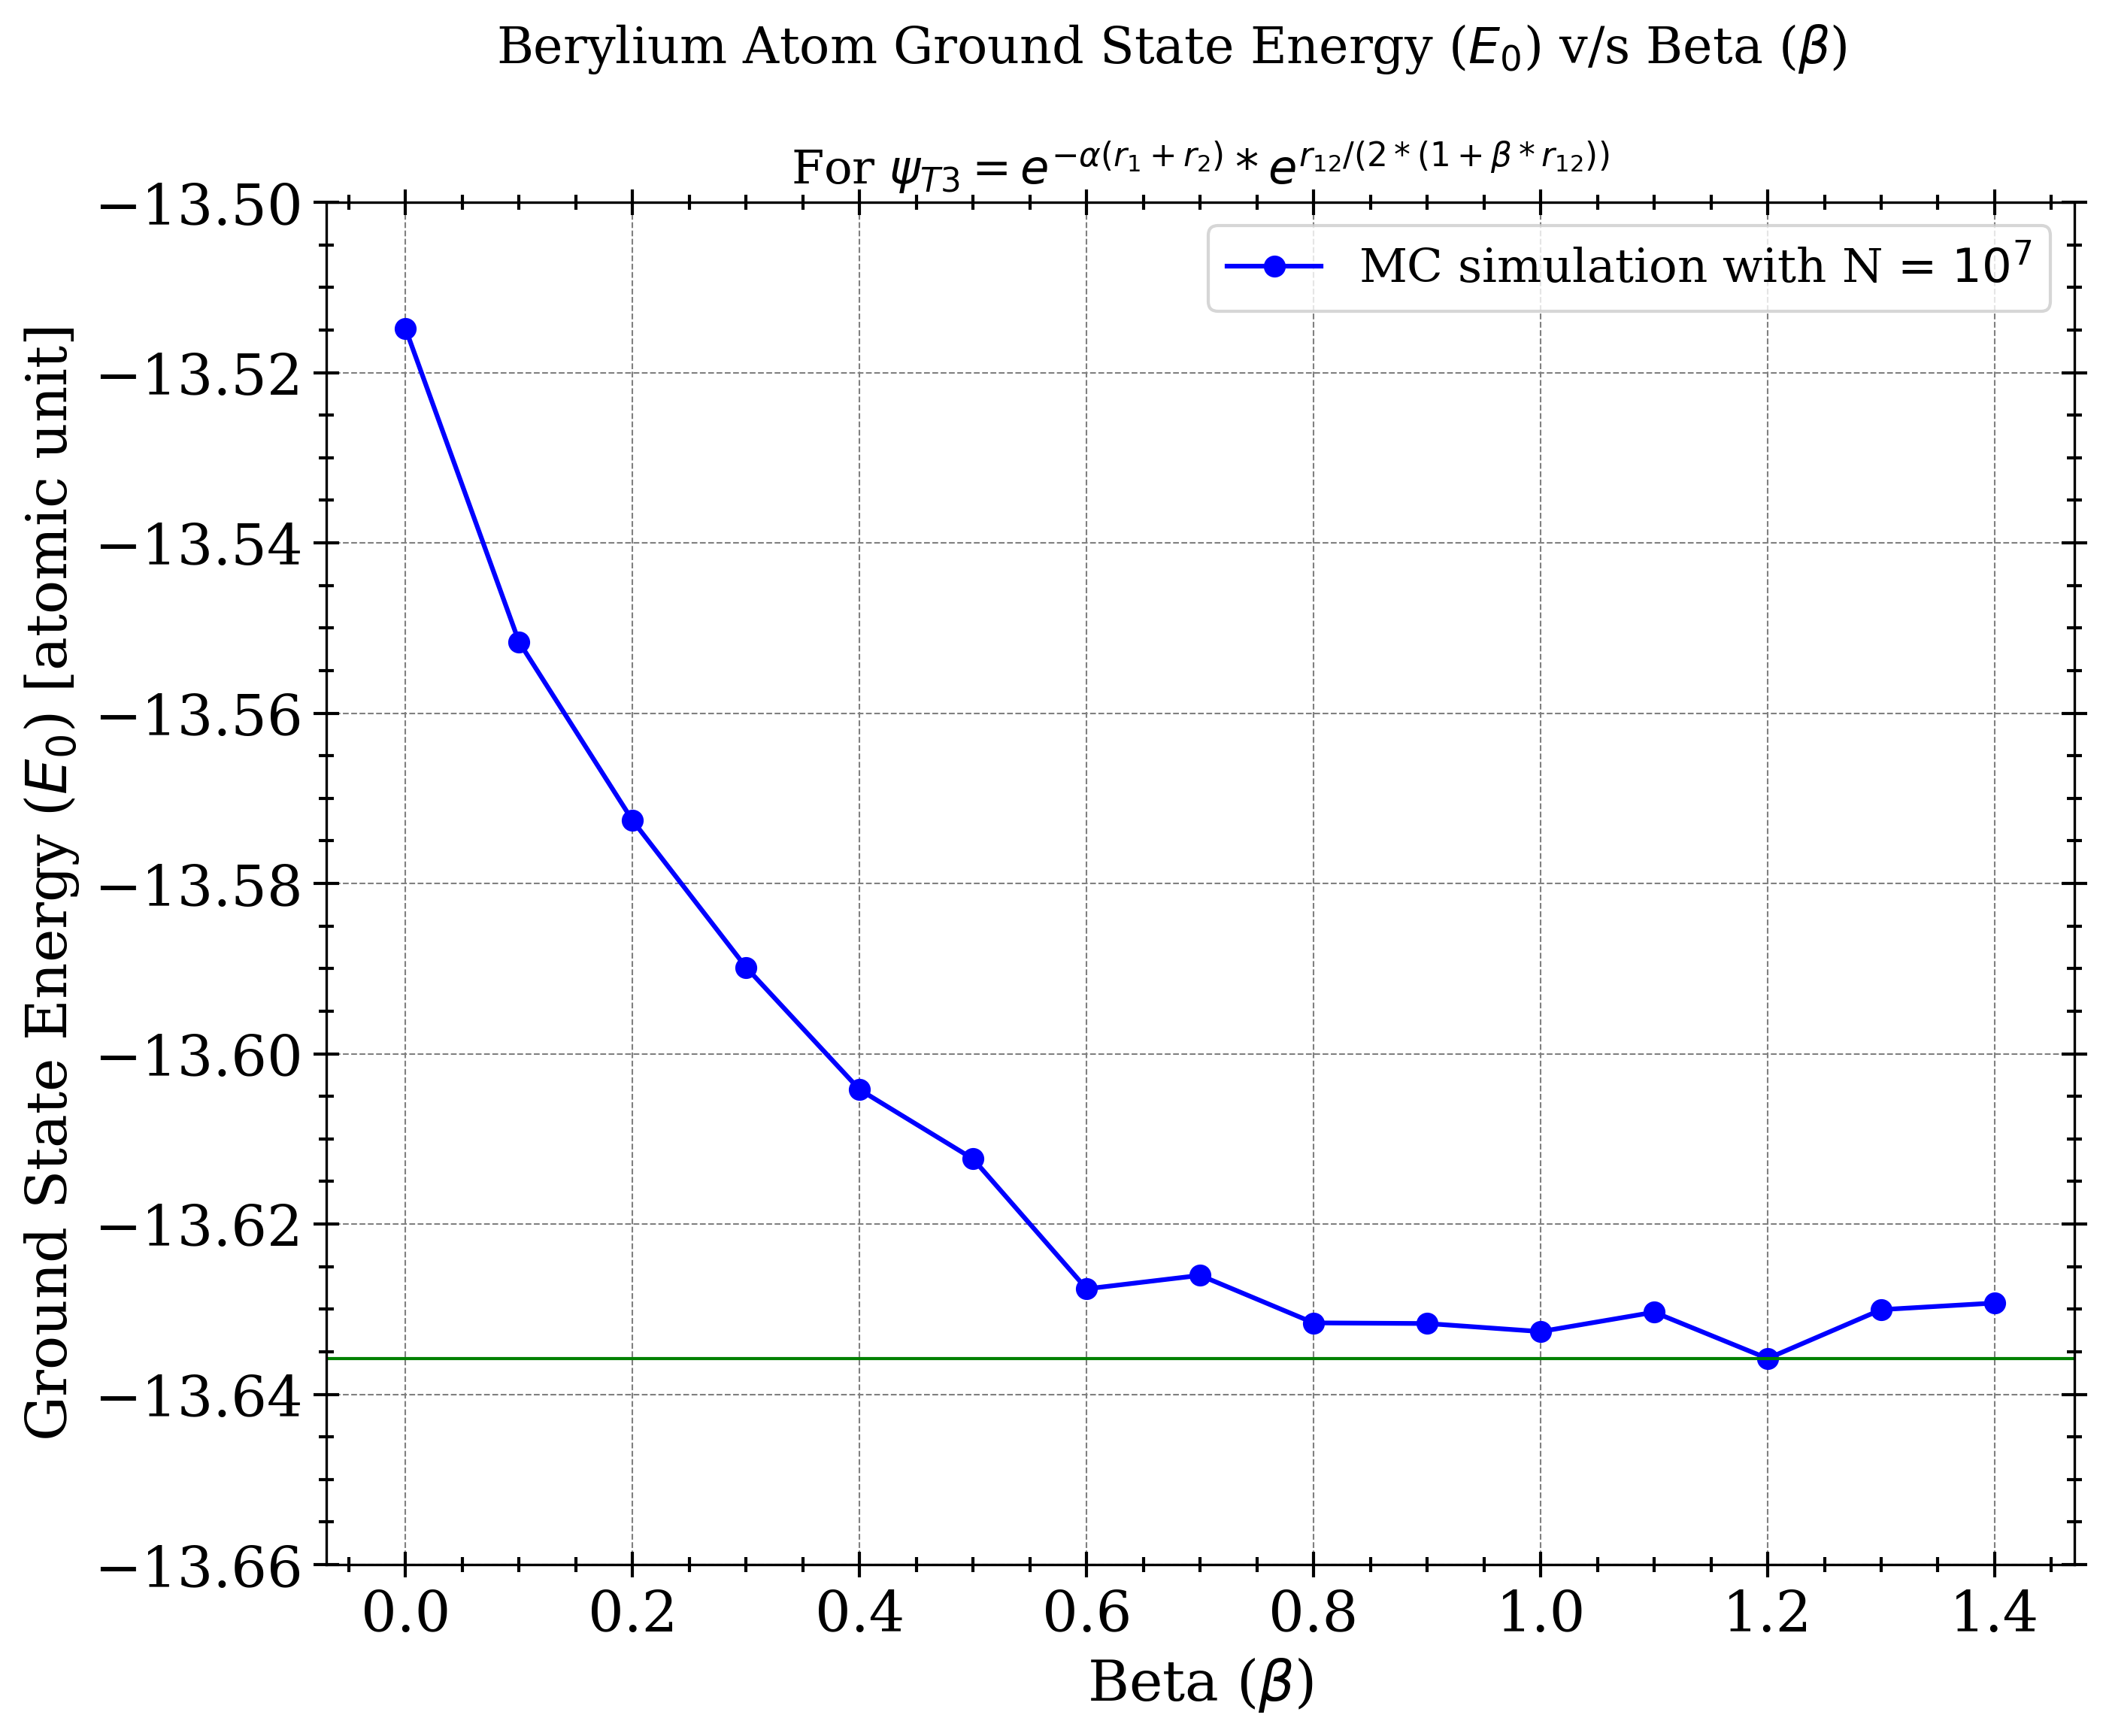

In [82]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.plot(b_val_3, energy_3, 'bo-', label = r'MC simulation with N = $10^7$')
plt.xlabel(r'Beta ($\beta$)')
plt.ylabel(r'Ground State Energy ($E_{0}$) [atomic unit]')
plt.suptitle('Berylium Atom Ground State Energy ($E_0$) v/s Beta ($\\beta$)', fontsize=16)
plt.title('For $\\psi_{T3} = e^{-\\alpha(r_1 + r_2)} * e^{r_{12} / (2*(1 + \\beta*r_{12}))}$', fontsize=15)
plt.axhline(y = np.min(energy_3), color='g', linestyle='-', linewidth=1)
yticks = set(np.round(plt.yticks()[0], 2))
yticks.add(round(np.min(energy_3), 2))
plt.yticks(sorted(yticks))
plt.legend()
plt.grid(True)

In [83]:
# making the dataframe contaning the mean energy and varivance for each value of alpha
df_3 = pd.DataFrame({r'Parameter $\beta$': b_val_3, r'Mean Energy $<H>$': energy_3, r' Variance $\sigma^{2}$': var_3})

print('anstaz 2 ')
df_3

anstaz 2 


Parameter $\beta$  Mean Energy $<H>$   Variance $\sigma^{2}$
0                 0.0         -13.514840                3.349591
1                 0.1         -13.551633                2.763239
2                 0.2         -13.572599                2.369563
3                 0.3         -13.589846                2.221211
4                 0.4         -13.604208                2.011260
5                 0.5         -13.612352                2.044172
6                 0.6         -13.627608                2.173240
7                 0.7         -13.626024                1.958835
8                 0.8         -13.631605                2.003071
9                 0.9         -13.631680                1.803589
10                1.0         -13.632626                1.858502
11                1.1         -13.630351                2.250644
12                1.2         -13.635791                1.776276
13                1.3         -13.630051                1.627593
14                1.4         -13.629274                2.255648

In [29]:
# scanning over the grid around the optimum values
s = 1.0             # step length
n_th = 1e3          # thermalization iterations
n = 1e7             # no. of monte carlo iterations
z = 4               # for Berylium charge = 4


# Create 2D grid of parameters
alpha_values_3 = np.linspace(3, 4, 6)  
beta_values_3 = np.linspace(0.8, 1.4, 6)   

# Initialize arrays to store results
energy_grid_3 = np.zeros((len(alpha_values_3), len(beta_values_3)))
variance_grid_3 = np.zeros((len(alpha_values_3), len(beta_values_3)))

# Loop over all parameter combinations
for i, a in tqdm(enumerate(alpha_values_3)):
    for j, b in enumerate(beta_values_3):
        # Run VMC simulation with these parameters
        e, v = vmc(psi_t3,  local_energy_3 , a, b, z, n, n_th, s)
        energy_grid_3[i, j] = e
        variance_grid_3[i, j] = v

6it [52:31, 525.21s/it] 


In [30]:
# Find the minimum energy and corresponding parameters
min_idx = np.unravel_index(np.argmin(energy_grid_3), energy_grid_3.shape)
opt_alpha_3 = alpha_values_3[min_idx[0]]
opt_beta_3 = beta_values_3[min_idx[1]]
min_energy_3 = energy_grid_3[min_idx]

print(f"Optimal parameters: α = {opt_alpha_3:.3f}, β = {opt_beta_3:.3f}")
print(f"Minimum energy: {min_energy_3:.6f} (in atomic units) or {4*13.6*min_energy_3:.6f} (in eV)")

r12_3 = r12(psi_t3, local_energy_3, opt_alpha_3, opt_beta_3, z, n, n_th, s)
print(f"mean distance r_{12} = {r12_3:.2f}")

Optimal parameters: α = 3.800, β = 0.920
Minimum energy: -13.643691 (in atomic units) or -742.216811 (in eV)
mean distance r_12 = 0.61


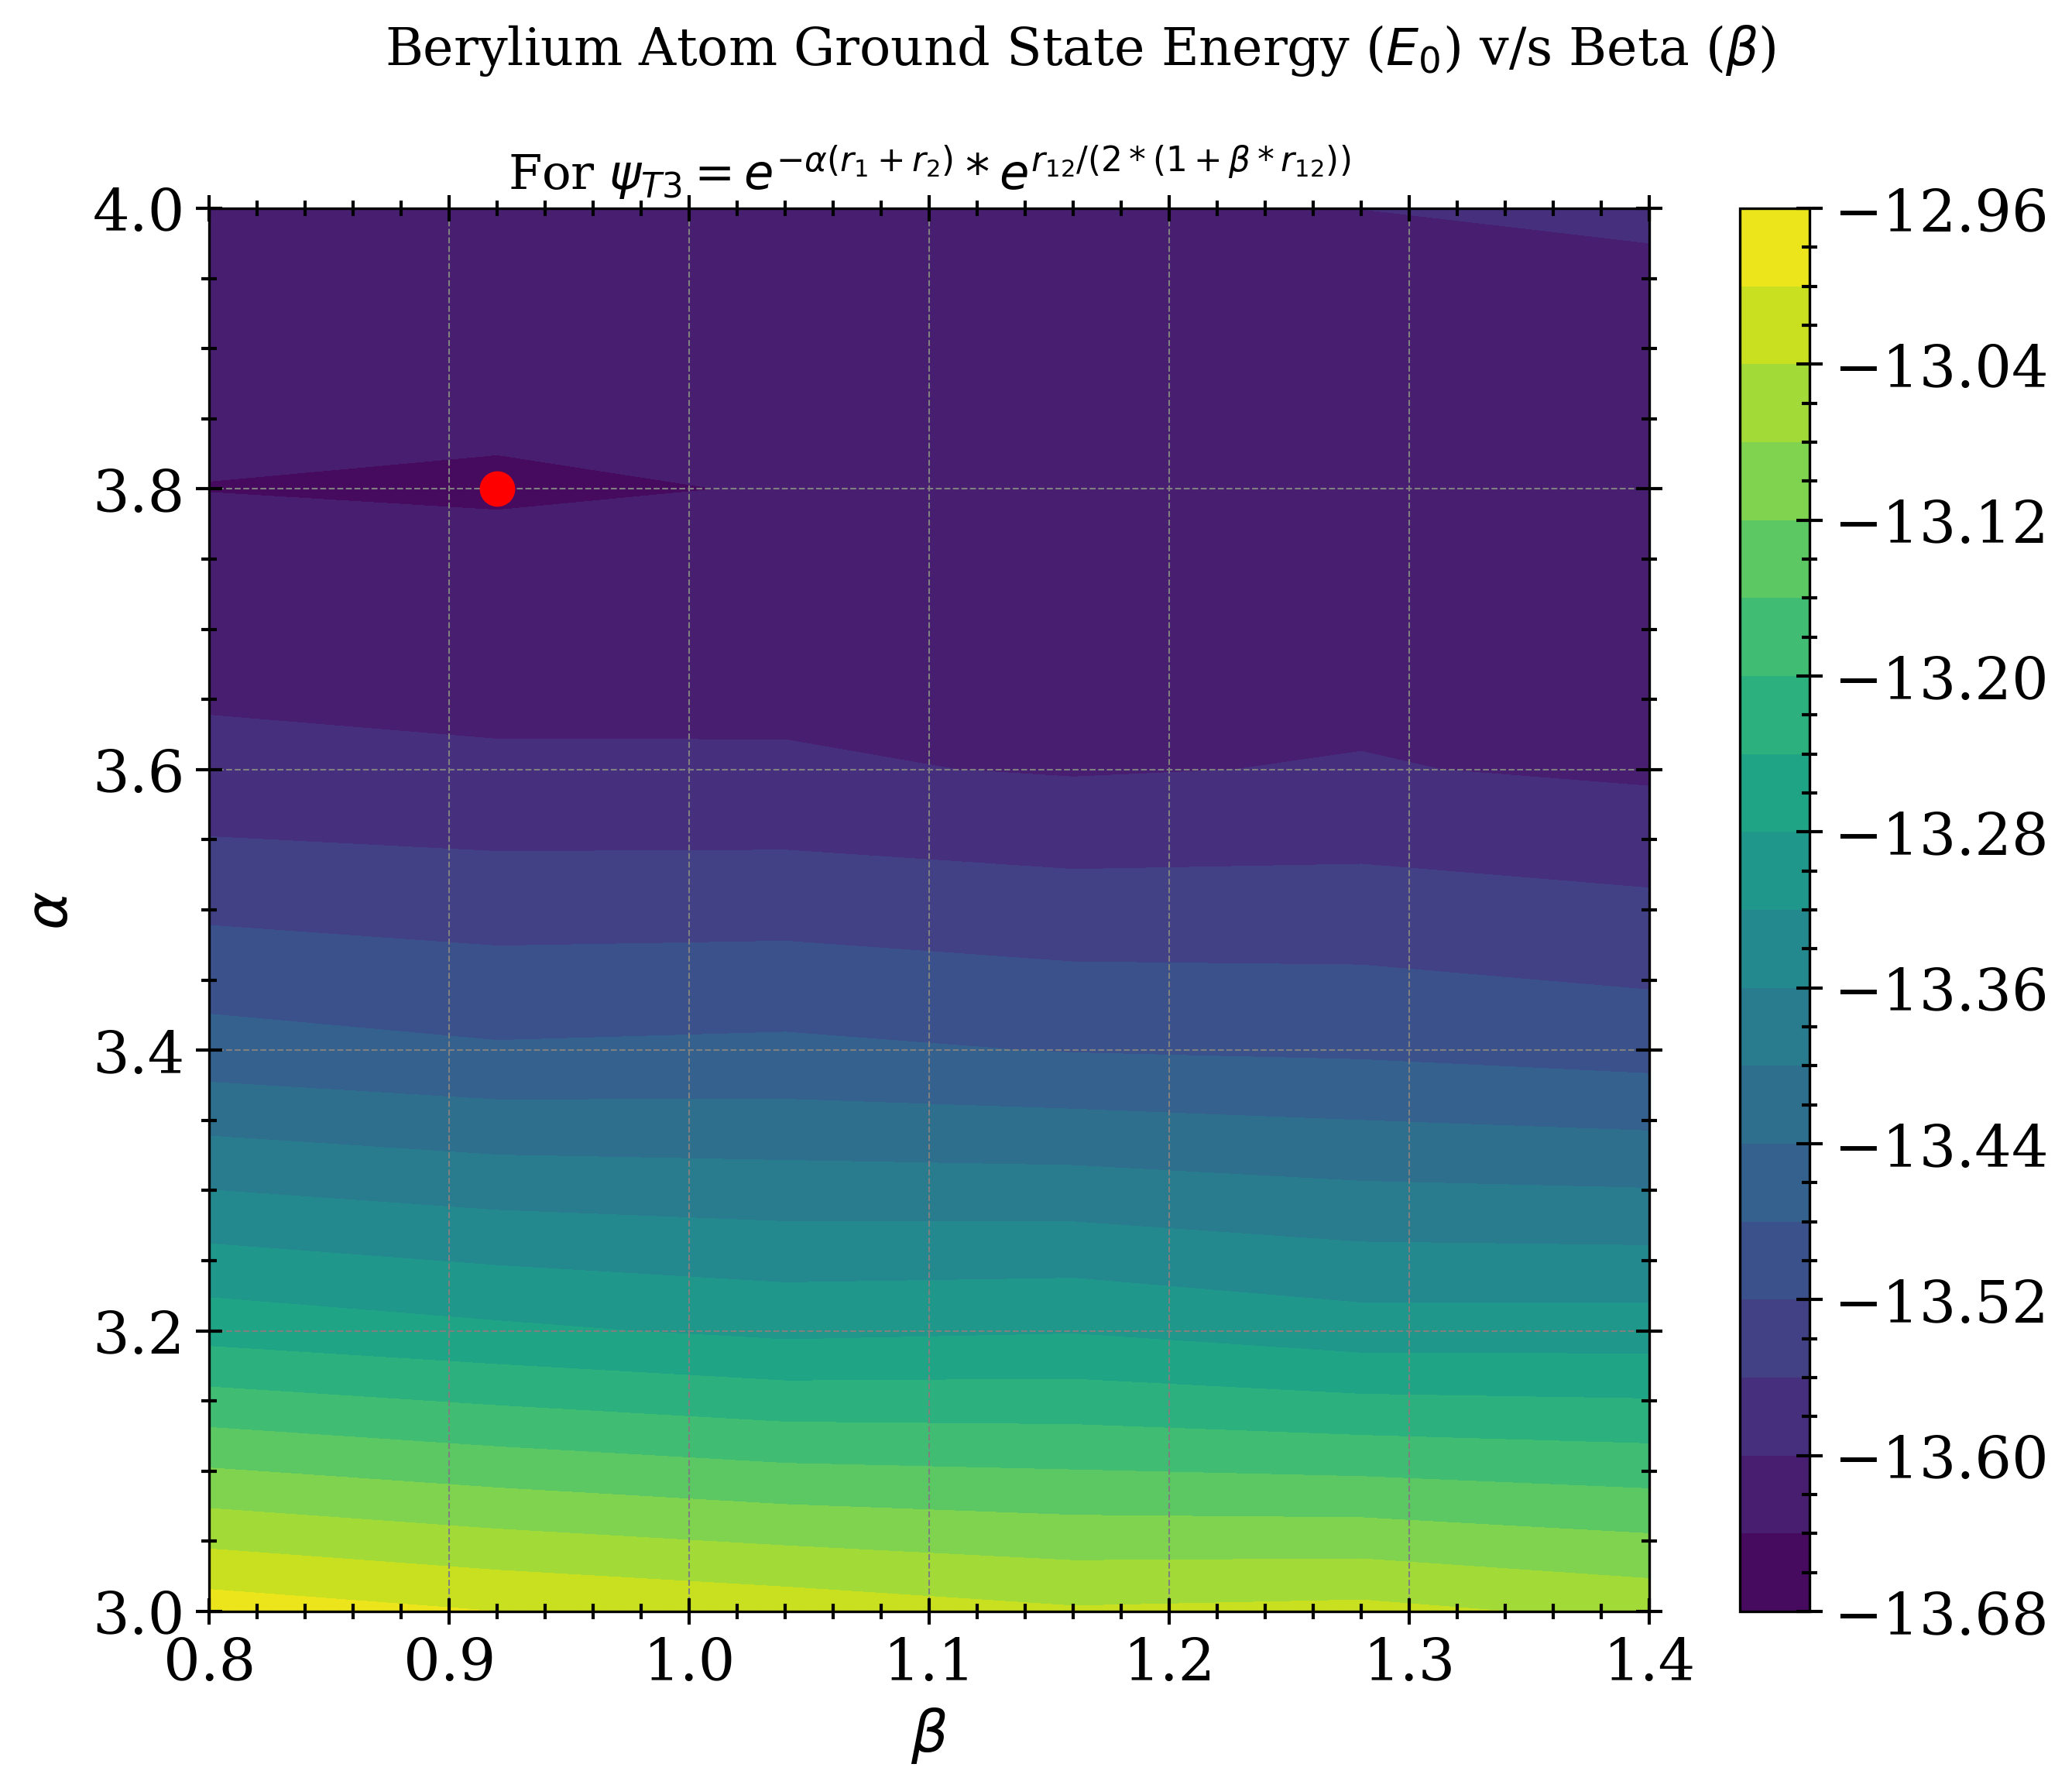

In [31]:
# Create a contour plot
fig, ax = plt.subplots(figsize=(10, 8))
X_3, Y_3 = np.meshgrid(beta_values_3, alpha_values_3)
contour = ax.contourf(X_3, Y_3, energy_grid_3, 20, cmap=cm.viridis)
fig.colorbar(contour, ax=ax)

# Mark the minimum point
ax.plot(opt_beta_3, opt_alpha_3, 'ro', markersize=10)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\alpha$')
plt.suptitle('Berylium Atom Ground State Energy ($E_0$) v/s Beta ($\\beta$)', fontsize=16)
plt.title('For $\\psi_{T3} = e^{-\\alpha(r_1 + r_2)} * e^{r_{12} / (2*(1 + \\beta*r_{12}))}$', fontsize=15)
plt.show()


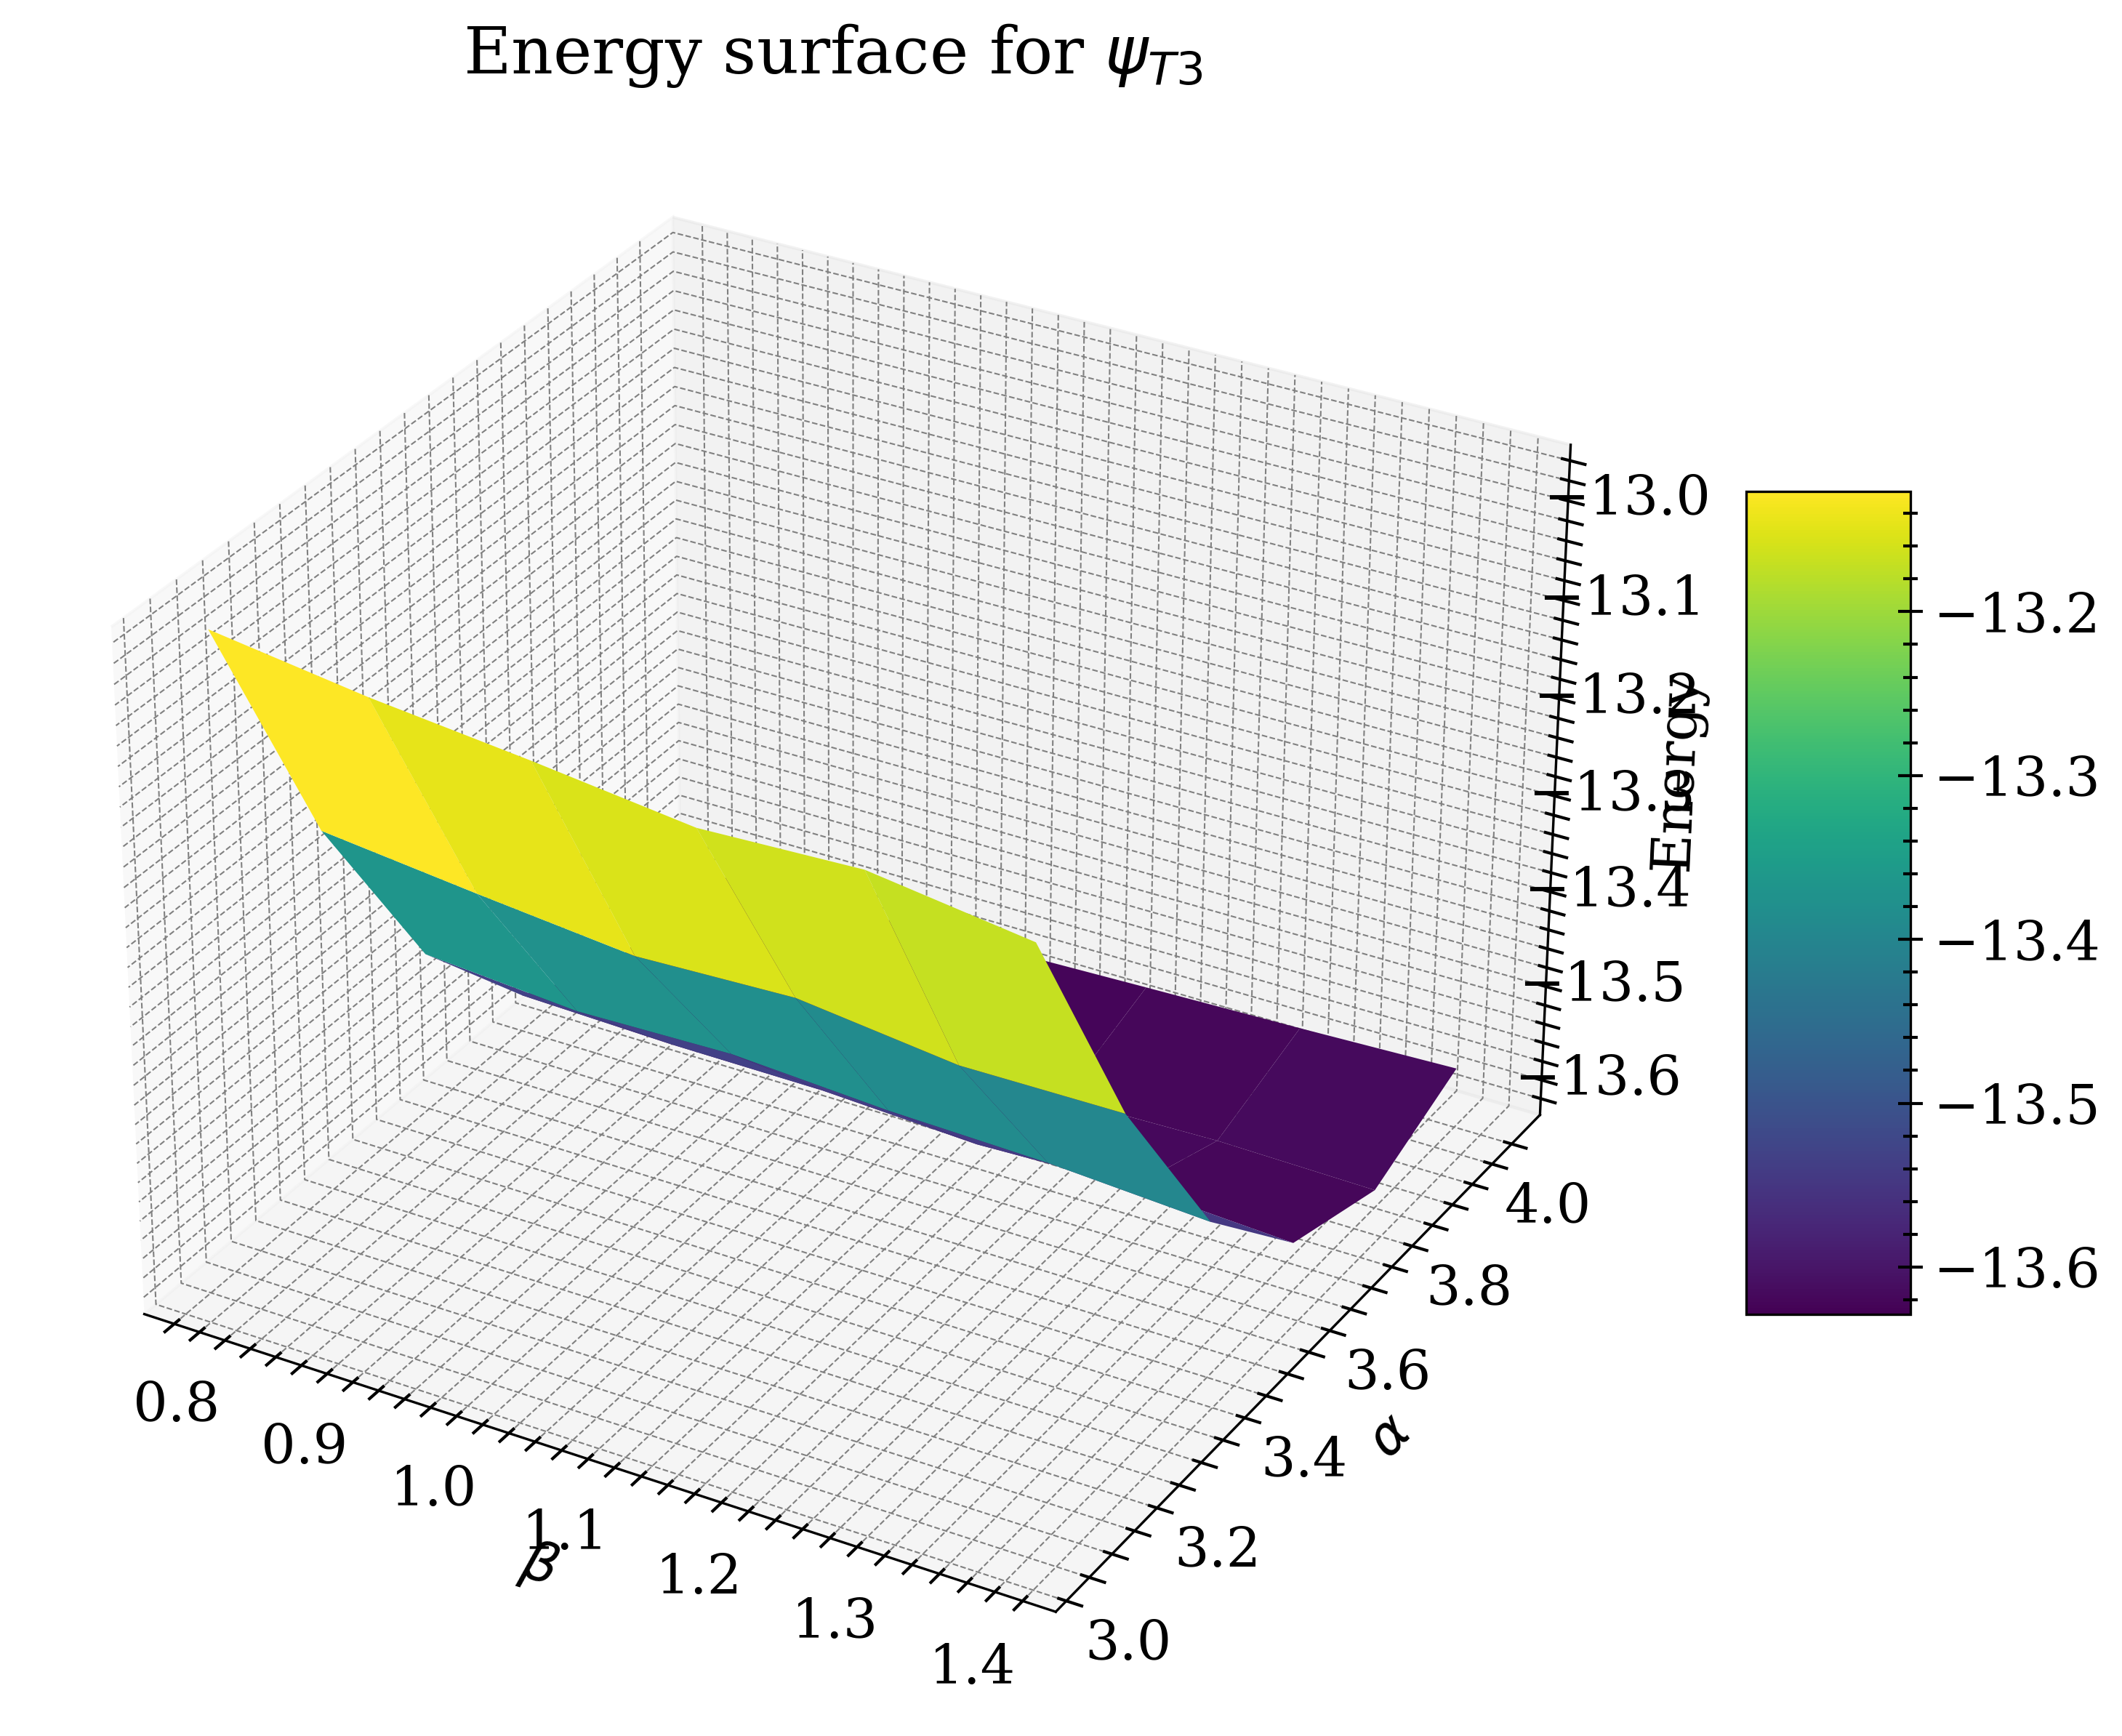

In [32]:
# create the 3-D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
surf_3 = ax.plot_surface(X_3, Y_3, energy_grid_3, cmap=cm.viridis, edgecolor='none')
fig.colorbar(surf_3, ax=ax, shrink=0.5, aspect=5)

ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\alpha$')
ax.set_zlabel('Energy')
ax.set_title('Energy surface for $\psi_{T3}$')
plt.show()

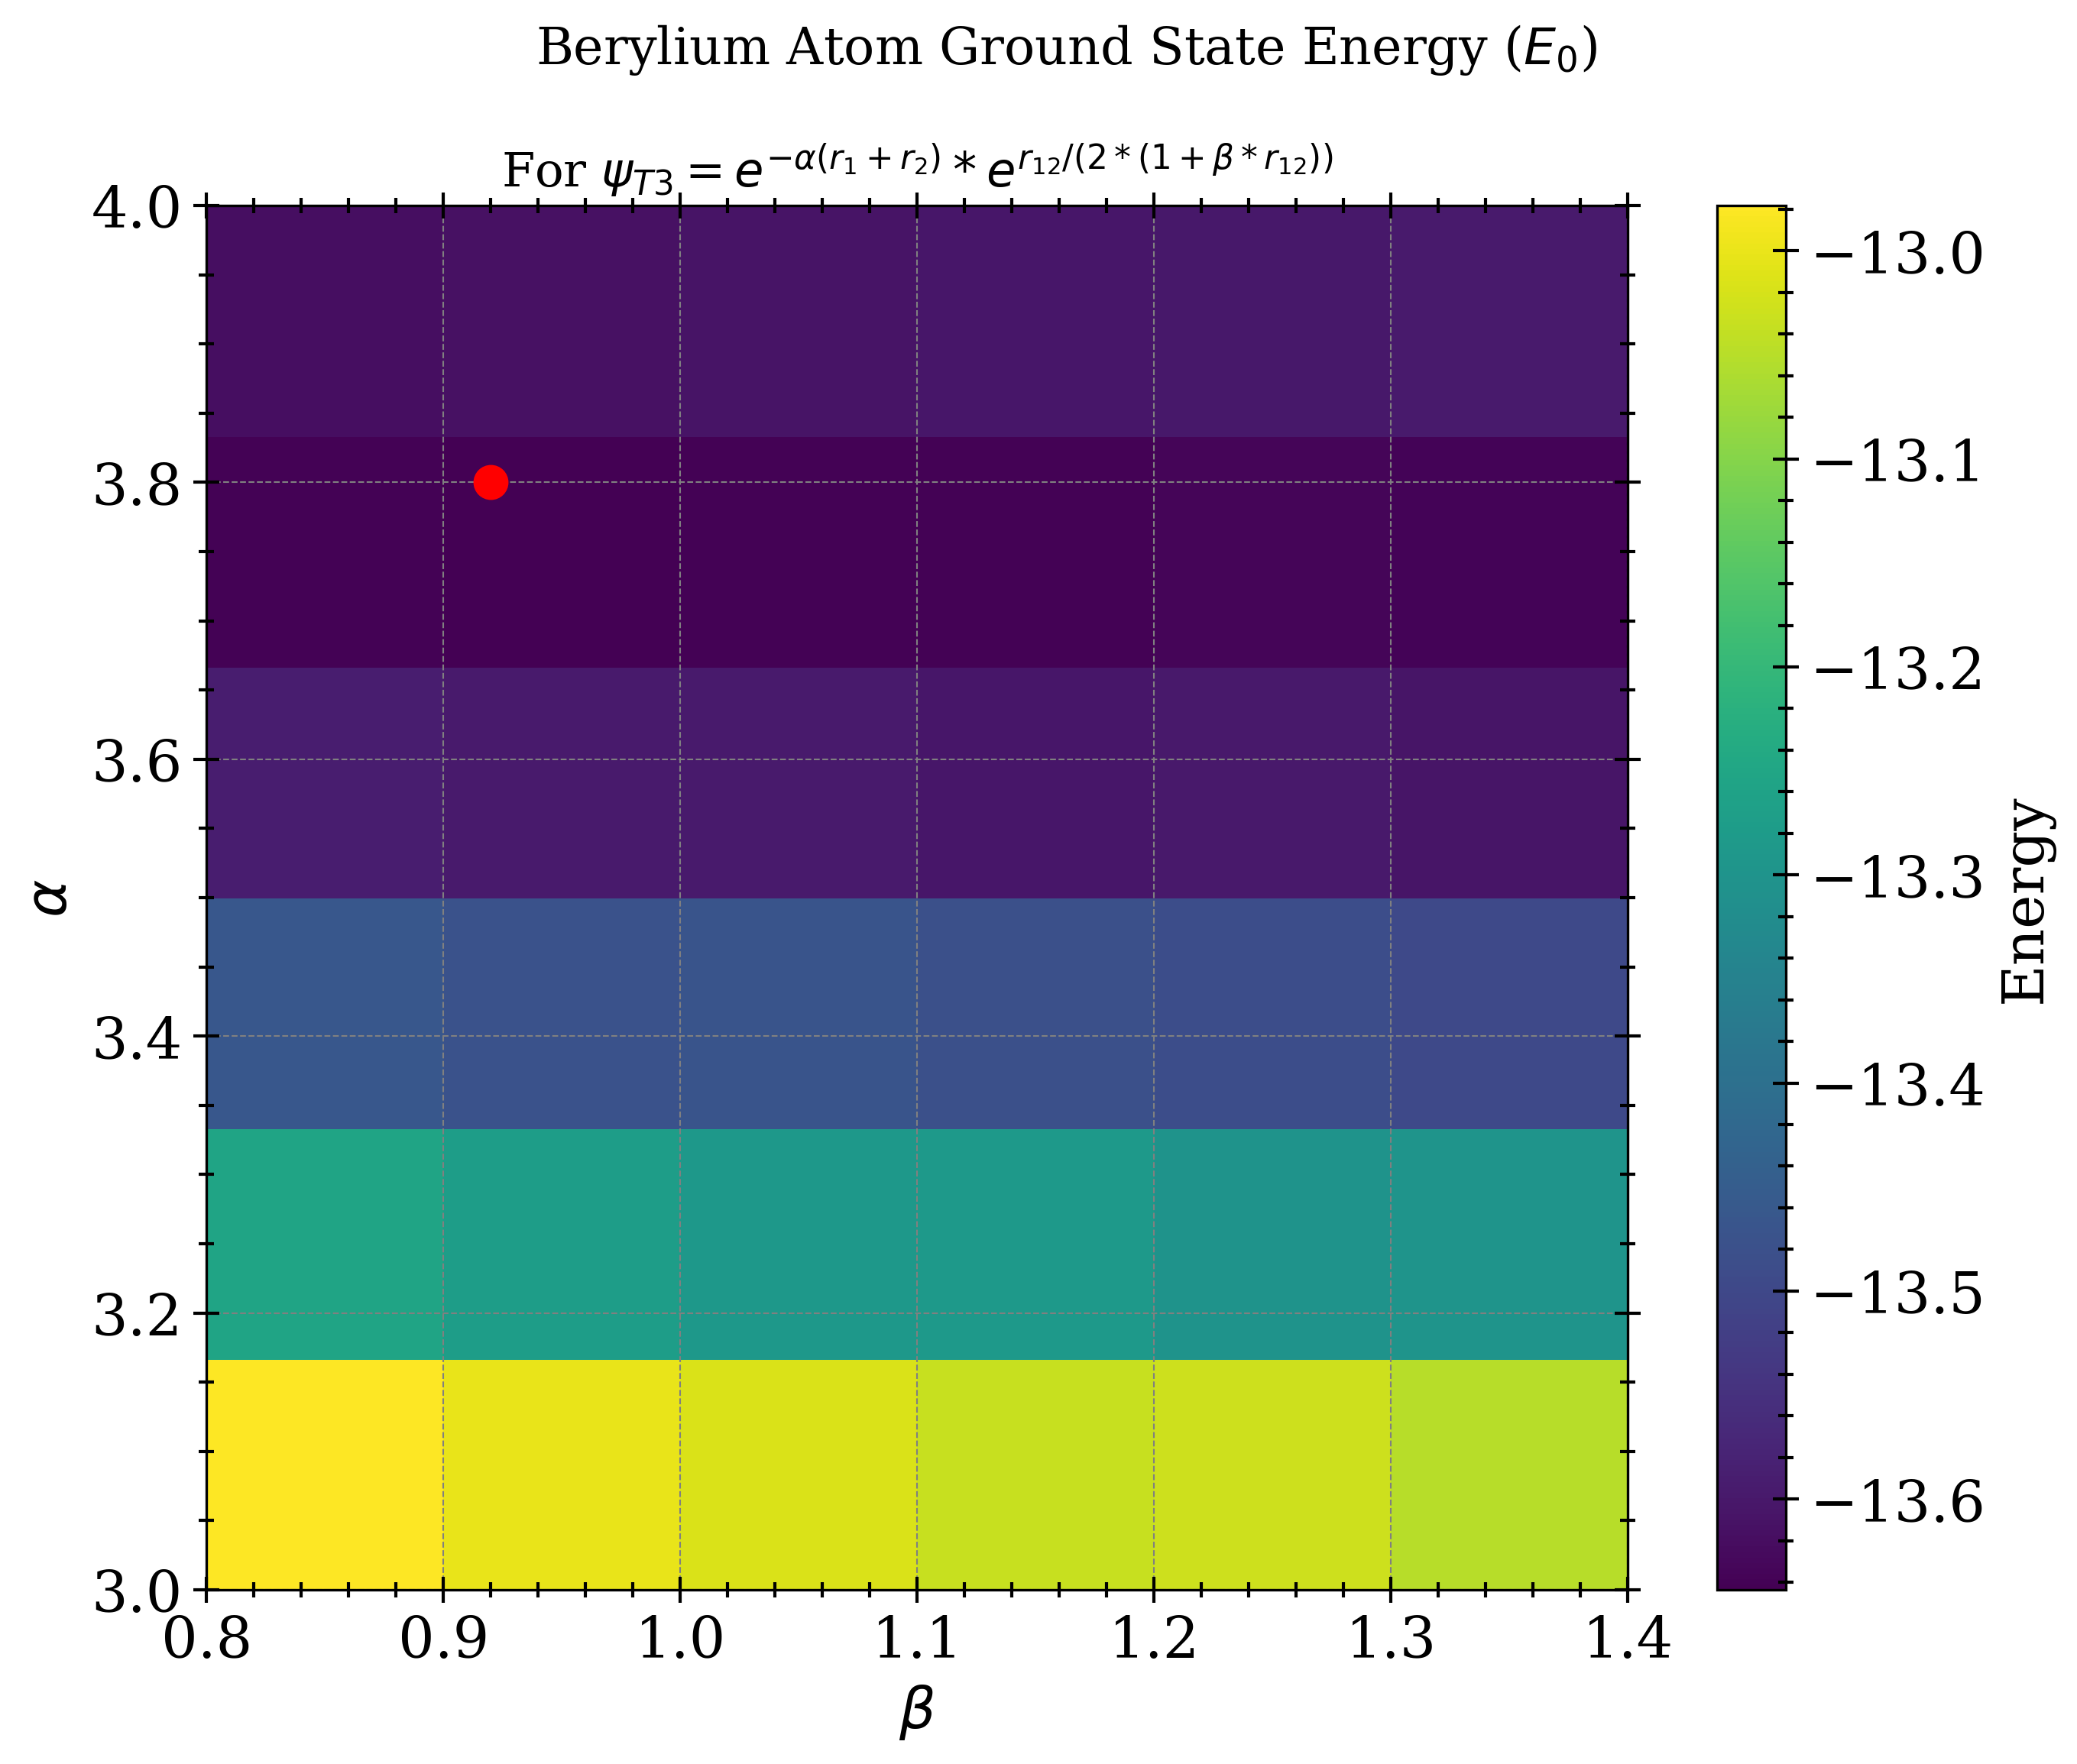

In [85]:
# create the heat map
plt.figure(figsize=(10, 8))
plt.imshow(energy_grid_3, origin='lower', extent=[beta_values_3[0], beta_values_3[-1], 
                                               alpha_values_3[0], alpha_values_3[-1]], 
           aspect='auto', cmap='viridis')
plt.plot(opt_beta_3, opt_alpha_3, 'ro', markersize=10)
plt.colorbar(label='Energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha$')
plt.suptitle('Berylium Atom Ground State Energy ($E_0$)', fontsize=16)
plt.title('For $\\psi_{T3} = e^{-\\alpha(r_1 + r_2)} * e^{r_{12} / (2*(1 + \\beta*r_{12}))}$', fontsize=15)
plt.show()

In [34]:
# Find the index of the minimum in e
a_idx, b_idx = np.unravel_index(np.argmin(energy_grid_3), energy_grid_3.shape)

# Select 3x3 values around the minimum
a_selected = alpha_values_3[a_idx-1:a_idx+2]
b_selected = beta_values_3[b_idx-1:b_idx+2]
e_block = energy_grid_3[b_idx-1:b_idx+2, a_idx-1:a_idx+2]
v_block = variance_grid_3[b_idx-1:b_idx+2, a_idx-1:a_idx+2]

# Flatten and create DataFrame
A, B = np.meshgrid(a_selected, b_selected)
df_3 = pd.DataFrame({
    r'$\alpha$': A.flatten(),
    r'$\beta$': B.flatten(),
    '$E$': e_block.flatten(),
    '$V$': v_block.flatten()
})

print(f"mean distance r_{12} = {r12_3:.2f}")
df_3

mean distance r_12 = 0.61


$\alpha$  $\beta$        $E$        $V$
0       3.6     0.80 -13.035015  15.918375
1       3.8     0.80 -13.028744  14.227648
2       4.0     0.80 -13.050683  14.241627
3       3.6     0.92 -13.282600   9.756014
4       3.8     0.92 -13.301539  10.497386
5       4.0     0.92 -13.300392   9.984556
6       3.6     1.04 -13.481763   6.091666
7       3.8     1.04 -13.486148   6.060867
8       4.0     1.04 -13.496267   7.505470

In [35]:
# Convert DataFrame to LaTeX table string
latex_table_3 = df_3.to_latex(
    index=False,           # Exclude index column
    header=True,           # Include column headers
    float_format="%.6f",   # Format float values
    caption="Sample Table", # Add caption
    label="tab:sample_table", # Add label for referencing
    column_format="lcc"    # Align columns (left, center, center)
)

# Print the LaTeX table string
print(latex_table_3)

\begin{table}
\centering
\caption{Sample Table}
\label{tab:sample_table}
\begin{tabular}{lcc}
\toprule
 \$\textbackslash alpha\$ &  \$\textbackslash beta\$ &        \$E\$ &       \$V\$ \\
\midrule
 3.600000 & 0.800000 & -13.035015 & 15.918375 \\
 3.800000 & 0.800000 & -13.028744 & 14.227648 \\
 4.000000 & 0.800000 & -13.050683 & 14.241627 \\
 3.600000 & 0.920000 & -13.282600 &  9.756014 \\
 3.800000 & 0.920000 & -13.301539 & 10.497386 \\
 4.000000 & 0.920000 & -13.300392 &  9.984556 \\
 3.600000 & 1.040000 & -13.481763 &  6.091666 \\
 3.800000 & 1.040000 & -13.486148 &  6.060867 \\
 4.000000 & 1.040000 & -13.496267 &  7.505470 \\
\bottomrule
\end{tabular}
\end{table}

